In [1]:
from pathlib import Path
from shutil import copyfile
import pickle

Load the general math/data manipulation packages

In [2]:
import numpy as np
import pandas as pd

Load the packages related to the Gaussian Process Regressor:

In [3]:
import gpflow
import tensorflow as tf

In [4]:
from gpflow.utilities import print_summary

In [5]:
tf.config.set_visible_devices([], 'GPU')

In [6]:
import matplotlib.pyplot as plt

Load the CasADi package used for optimization:

In [7]:
import casadi

Import MATLAB engine and start it in the background since this takes a while:

In [8]:
import matlab.engine

In [9]:
eng = matlab.engine.start_matlab()

In [10]:
eng.load_system("../Simulink/polydome", background = True)

Copy the experimental data set to the CARNOT input location: 

In [11]:
exp_id = 'Exp6'

In [12]:
copyfile(f"../Data/Experimental_data_WDB/{exp_id}_WDB.mat", "../Data/input_WDB.mat")

'../Data/input_WDB.mat'

## Load the existing GP model

In [13]:
df_trainset = pd.read_pickle("gp_trainset.pkl")

In [14]:
x_scaler = pickle.load(open('x_scaler.pkl', 'rb'))

In [15]:
df_input = df_trainset.drop(columns = ['y'])
df_output = df_trainset['y']

In [16]:
np_input = df_input.to_numpy()
np_output = df_output.to_numpy().reshape(-1, 1)

In [17]:
np_input_sc = x_scaler.transform(np_input)

In [18]:
n_states = np_input_sc.shape[1]

In [19]:
k = gpflow.kernels.SquaredExponential(lengthscales=([1] * np_input.shape[1])) + gpflow.kernels.Constant()
print_summary(k)

╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value          │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0            │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ (7,)    │ float64 │ [1., 1., 1.... │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0            │
╘═════════════════════════════╧═══════════╧═════

In [20]:
model = gpflow.models.GPR(
    data = (np_input_sc, np_output), 
    kernel = k, 
    mean_function = None
    )
print_summary(model)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value          │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (7,)    │ float64 │ [1., 1., 1.... │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ Tru

Load exported params over the model "skeleton":

In [21]:
model_params_loaded = pickle.load(open(Path(Path.cwd(), 'gp_params.gpf'), 'rb'))

In [22]:
gpflow.utilities.multiple_assign(model, model_params_loaded)

In [23]:
print_summary(model)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                        │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 522.3146176324312                            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (7,)    │ float64 │ [398.28296795, 262.16471714, 1574.2697205... │
├─────────────────────────────────

## Set up the CasADi optimization problem

In [24]:
# Package the regression model in a CasADi callback
class GPR(casadi.Callback):
  def __init__(self, name,  opts={}):
    casadi.Callback.__init__(self)
    self.construct(name, opts)
    
  # Number of inputs and outputs
  def get_n_in(self): return 1
  def get_n_out(self): return 1

  def get_sparsity_in(self,i):
      return casadi.Sparsity.dense(n_states,1)

  def eval(self, arg):
    x_scaled = x_scaler.transform(np.array(arg[0]).reshape(1, -1))
    [mean, _] = model.predict_y(x_scaled)
    return [mean.numpy()]

In [25]:
# Instantiate the Callback (make sure to keep a reference to it!)
gpr = GPR('GPR', {"enable_fd":True})
print(gpr)

GPR:(i0[7])->(o0) CallbackInternal


In [219]:
T_set = 20
N_horizon = 5

### Define optimization variables

In [220]:
X = casadi.MX.sym("X", N_horizon, n_states)
W = casadi.MX.sym("W", N_horizon, 2)
x0_lags = casadi.MX.sym("lags", 1, n_states - 3)

Impose initial lags:

In [221]:
g = casadi.vec(X[0,3:] - x0_lags)

Impose disturbances:

In [222]:
g = casadi.vertcat(
    g,
    casadi.vec(X[:, :2] - W)
)

Compute objective:

In [223]:
J = casadi.norm_2(X.reshape((N_horizon, -1))[:,4] - T_set)

Fix input/output lags between time steps (equality constraints):

In [224]:
for idx in range(1, N_horizon):
    g = casadi.vertcat(
        g,
        X[idx, 3] - X[idx-1, 2],
        X[idx, 4] - gpr(X[idx-1,:]),
        X[idx, 5] - X[idx-1, 4],
        X[idx, 6] - X[idx-1, 5]
    )

Impose input inequality constraints:

In [225]:
g = casadi.vertcat(
    g,
    X[:, 2]
)

### Compile the optimization problem

Compile the parameter vector:

In [226]:
p = casadi.vertcat(
    casadi.vec(W),
    casadi.vec(x0_lags)
)

In [227]:
prob = {"x": casadi.vec(X), "f": J, "p": p, "g": g}
options = {"ipopt": {"hessian_approximation": "limited-memory", "max_iter": 100, 
                    "acceptable_tol": 1e-8, "acceptable_obj_change_tol": 1e-6}}

Get the solver object:

In [228]:
solver = casadi.nlpsol("solver","ipopt",prob, options)

Compute the `lbg` `ubg` since they are always the same:

In [250]:
Pel_max = 6300
COP_heat = 5
COP_cool = 5
u_min = - COP_cool * Pel_max
u_max = COP_heat * Pel_max

In [251]:
real_lbg = [0] * (4 + 2 * N_horizon + 4 * (N_horizon - 1)) + [u_min] * (N_horizon)
real_ubg = [0] * (4 + 2 * N_horizon + 4 * (N_horizon - 1)) + [u_max] * (N_horizon)

## Load CARNOT building with MATLAB backend

In [149]:
df = pd.read_pickle(f"../Data/CARNOT_output/{exp_id}_full.pkl")
df.head()

Power  Setpoint  OutsideTemp  SupplyTemp  \
timestamp                                                                   
2017-07-07 20:00:00+02:00  4651.034483      22.5         30.0        14.9   
2017-07-07 20:05:00+02:00  4634.896552      22.5         30.0        14.6   
2017-07-07 20:10:00+02:00  4620.620690      22.5         30.0        14.6   
2017-07-07 20:15:00+02:00  4449.233333      22.5         29.5        14.3   
2017-07-07 20:20:00+02:00    27.068966      22.5         29.5        18.5   

                           InsideTemp      SolRad          Heat  SimulatedTemp  
timestamp                                                                       
2017-07-07 20:00:00+02:00   23.100000  143.479467 -23255.172414      22.258988  
2017-07-07 20:05:00+02:00   23.016667  133.344633 -23174.482759      21.514439  
2017-07-07 20:10:00+02:00   22.900000  122.100633 -23103.103448      21.488865  
2017-07-07 20:15:00+02:00   22.733333  111.456233 -22246.166667      21.907265  
2017-07-07 20:20:00+02:00   22.700000  100.605500   -135.344828      23.201910

In [150]:
df_wdb = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_WDB.pkl")
df_wdb.head()

time     timestamp     zenith     azimuth         dni        dhi  \
0     0  201707072000  77.301874  289.483783  219.244645  95.527995   
1   300  201707072005  78.106572  290.326990  212.109089  89.880399   
2   600  201707072010  78.906360  291.172101  196.448414  84.549236   
3   900  201707072015  79.700825  292.019421  183.166538  78.957097   
4  1200  201707072020  80.489912  292.869248  166.672243  73.312077   

   OutsideTemp  Tsky_rad  relative_humidity  precipitation  cloud_index  \
0         30.0      24.0                 50          -9999          0.5   
1         30.0      24.0                 50          -9999          0.5   
2         30.0      24.0                 50          -9999          0.5   
3         29.5      23.5                 50          -9999          0.5   
4         29.5      23.5                 50          -9999          0.5   

   pressure  wind_speed  wind_direction        aoi  incidence_main  \
0     96300           0           -9999  77.301874           -9999   
1     96300           0           -9999  78.106572           -9999   
2     96300           0           -9999  78.906360           -9999   
3     96300           0           -9999  79.700825           -9999   
4     96300           0           -9999  80.489912           -9999   

   incidence_second  poa_direct  poa_diffuse  
0             -9999   48.193107    95.527995  
1             -9999   43.713976    89.880399  
2             -9999   37.799238    84.549236  
3             -9999   32.747988    78.957097  
4             -9999   27.537799    73.312077

In [151]:
runtime = df_wdb['time'].iloc[-1]
print(f"Experiment runtime: {runtime}")

Experiment runtime: 208500


In [152]:
eng.workspace['t0'] = float(df['InsideTemp'][0])

In [153]:
day_air_exchange_rate = 2.0
night_air_exchange_rate = 0.5

In [154]:
air_exchange_rate = np.zeros((df_wdb.shape[0], 2))
air_exchange_rate[:, 0] = df_wdb['time']
air_exchange_rate[:, 1] = np.where(df['Power'] < 100, day_air_exchange_rate, night_air_exchange_rate)
eng.workspace['air_exchange_rate'] = matlab.double(air_exchange_rate.tolist())

In [155]:
power = np.array([df_wdb['time'], df['Heat']]).T
eng.workspace['power'] = matlab.double(power.tolist())

In [156]:
df = pd.DataFrame(df).assign(time = df_wdb['time'].values)
df.head()

Power  Setpoint  OutsideTemp  SupplyTemp  \
timestamp                                                                   
2017-07-07 20:00:00+02:00  4651.034483      22.5         30.0        14.9   
2017-07-07 20:05:00+02:00  4634.896552      22.5         30.0        14.6   
2017-07-07 20:10:00+02:00  4620.620690      22.5         30.0        14.6   
2017-07-07 20:15:00+02:00  4449.233333      22.5         29.5        14.3   
2017-07-07 20:20:00+02:00    27.068966      22.5         29.5        18.5   

                           InsideTemp      SolRad          Heat  \
timestamp                                                         
2017-07-07 20:00:00+02:00   23.100000  143.479467 -23255.172414   
2017-07-07 20:05:00+02:00   23.016667  133.344633 -23174.482759   
2017-07-07 20:10:00+02:00   22.900000  122.100633 -23103.103448   
2017-07-07 20:15:00+02:00   22.733333  111.456233 -22246.166667   
2017-07-07 20:20:00+02:00   22.700000  100.605500   -135.344828   

                           SimulatedTemp  time  
timestamp                                       
2017-07-07 20:00:00+02:00      22.258988     0  
2017-07-07 20:05:00+02:00      21.514439   300  
2017-07-07 20:10:00+02:00      21.488865   600  
2017-07-07 20:15:00+02:00      21.907265   900  
2017-07-07 20:20:00+02:00      23.201910  1200

## Control loop

### Initiation setup

In [277]:
current_timestamp = 1500

In [278]:
df_power = df['Heat']
df_power = pd.DataFrame(df_power).assign(time = df_wdb['time'].values)
df_power.loc[df_power['time'] >= current_timestamp, 'Heat'] = np.NaN

### Compute input to apply at current time step

In [281]:
u_1 = float(df_power.loc[df['time'] == (current_timestamp - 300 * 1), 'Heat'])

y_1 = float(df.loc[df['time'] == (current_timestamp - 300 * 1), 'SimulatedTemp'])
y_2 = float(df.loc[df['time'] == (current_timestamp - 300 * 2), 'SimulatedTemp'])
y_3 = float(df.loc[df['time'] == (current_timestamp - 300 * 3), 'SimulatedTemp'])

In [282]:
real_x0 = np.array([u_1, y_1, y_2, y_3])

In [283]:
iter_idx = (df['time'] >= current_timestamp)
real_W = df[iter_idx].iloc[:N_horizon, [5, 2]].to_numpy()

In [284]:
real_p = casadi.vertcat(
    casadi.vec(real_W),
    casadi.vec(real_x0)
)

In [285]:
res = solver(p = real_p, lbg = real_lbg, ubg = real_ubg)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       70
Number of nonzeros in inequality constraint Jacobian.:        5
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       35
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       30
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        5
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Apply the first computed input as the next input:

In [295]:
df_power.loc[df_power['time'] == current_timestamp, 'Heat'] = res['x'].reshape((N_horizon, -1))[0, 2]

Simulate the building including the current input:

In [299]:
power = np.array(df_power[['time', 'Heat']].dropna())

In [303]:
eng.workspace['power'] = matlab.double(power.tolist())

In [304]:
eng.set_param('polydome', 'StopTime', str(current_timestamp + 300), nargout = 0)

In [305]:
eng.workspace['result'] = eng.sim('polydome')

Interpret the MATLAB results as python:

In [306]:
dict_simulation = {}
dict_simulation['values'] = np.asarray(eng.eval('result.SimulatedTemp.Data')).reshape(-1)
dict_simulation['time'] = np.asarray(eng.eval('result.SimulatedTemp.Time')).reshape(-1)

In [307]:
df_simulation = pd.DataFrame(dict_simulation)
#df_simulation['time'] = df_simulation['time'].astype(int)
df_simulation.set_index('time', inplace = True, drop = True)

In [308]:
df_simulation['timestamp'] = df.index[0] + df_simulation.index.map(lambda x: pd.Timedelta(seconds = x))

In [309]:
df_simulation = df_simulation.reset_index().set_index('timestamp')

In [313]:
df_resampled_5 = df_simulation['values'].resample('5min').mean().pad()

In [327]:
df_simulation = pd.concat([df['time'], df_resampled_5], axis = 1)

Update the simulated temperature (output data) with the new info from this step:

In [331]:
df.loc[:, 'SimulatedTemp'] = df_simulation['values']

In [332]:
df

Power  Setpoint  OutsideTemp  SupplyTemp  \
timestamp                                                                   
2017-07-07 20:00:00+02:00  4651.034483      22.5         30.0        14.9   
2017-07-07 20:05:00+02:00  4634.896552      22.5         30.0        14.6   
2017-07-07 20:10:00+02:00  4620.620690      22.5         30.0        14.6   
2017-07-07 20:15:00+02:00  4449.233333      22.5         29.5        14.3   
2017-07-07 20:20:00+02:00    27.068966      22.5         29.5        18.5   
...                                ...       ...          ...         ...   
2017-07-10 05:35:00+02:00    28.206897      22.5         18.0        23.0   
2017-07-10 05:40:00+02:00    27.965517      22.5         18.0        23.0   
2017-07-10 05:45:00+02:00    30.413793      22.5         18.0        23.0   
2017-07-10 05:50:00+02:00    29.800000      22.5         18.0        23.0   
2017-07-10 05:55:00+02:00    31.931034      22.5         18.0        23.0   

                           InsideTemp      SolRad          Heat  \
timestamp                                                         
2017-07-07 20:00:00+02:00   23.100000  143.479467 -23255.172414   
2017-07-07 20:05:00+02:00   23.016667  133.344633 -23174.482759   
2017-07-07 20:10:00+02:00   22.900000  122.100633 -23103.103448   
2017-07-07 20:15:00+02:00   22.733333  111.456233 -22246.166667   
2017-07-07 20:20:00+02:00   22.700000  100.605500   -135.344828   
...                               ...         ...           ...   
2017-07-10 05:35:00+02:00   22.333333    0.000000    141.034483   
2017-07-10 05:40:00+02:00   22.383333    0.000000    139.827586   
2017-07-10 05:45:00+02:00   22.366667    0.000000    152.068966   
2017-07-10 05:50:00+02:00   22.333333    0.000000    149.000000   
2017-07-10 05:55:00+02:00   22.350000    0.000000    159.655172   

                           SimulatedTemp    time  
timestamp                                         
2017-07-07 20:00:00+02:00      22.186572       0  
2017-07-07 20:05:00+02:00      21.512325     300  
2017-07-07 20:10:00+02:00      21.489900     600  
2017-07-07 20:15:00+02:00      22.073906     900  
2017-07-07 20:20:00+02:00      23.232675    1200  
...                                  ...     ...  
2017-07-10 05:35:00+02:00            NaN  207300  
2017-07-10 05:40:00+02:00            NaN  207600  
2017-07-10 05:45:00+02:00            NaN  207900  
2017-07-10 05:50:00+02:00            NaN  208200  
2017-07-10 05:55:00+02:00            NaN  208500  

[696 rows x 9 columns]

Keep track of the all the prediction horizon, to add to the graph:

In [340]:
T_sim_horizon = np.array(gpr(res['x'].reshape((N_horizon, -1)).T))
T_sim_horizon

array([[22.79605454, 22.91609847, 23.08086156, 23.18446746, 23.81619112]])

In [352]:
simul_idx = (df_simulation['time'] >= current_timestamp) & (df_simulation['time'] < (current_timestamp + N_horizon * 300))

In [367]:
df_T_sim_horizon = df_simulation[simul_idx].copy()
df_T_sim_horizon.loc[:, 'values'] = T_sim_horizon.reshape((-1, ))
df_T_sim_horizon

time     values
timestamp                                 
2017-07-07 20:25:00+02:00  1500  22.796055
2017-07-07 20:30:00+02:00  1800  22.916098
2017-07-07 20:35:00+02:00  2100  23.080862
2017-07-07 20:40:00+02:00  2400  23.184467
2017-07-07 20:45:00+02:00  2700  23.816191

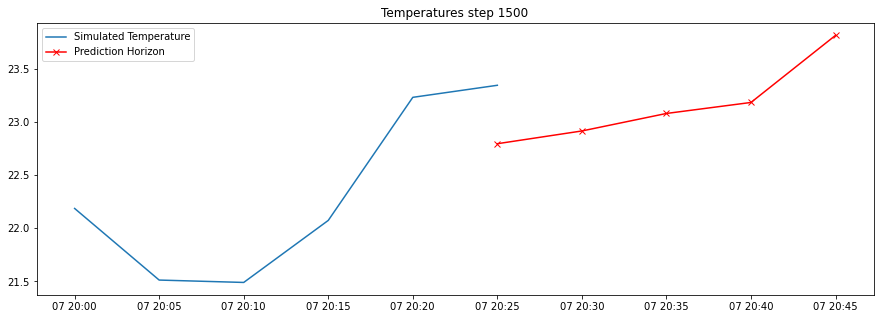

In [384]:
plt.figure(figsize = (15, 5))
plt.plot(df_simulation.index, df_simulation['values'], label = 'Simulated Temperature')
plt.plot(df_T_sim_horizon.index, df_T_sim_horizon['values'], label = 'Prediction Horizon', color = 'red', marker = 'x')
#plt.plot(df.index, df['InsideTemp'], label = 'Inside Temperature')
#plt.plot(df.index, df['OutsideTemp'], label = 'Outside Temperature')
plt.title(f'Temperatures step {current_timestamp}')
plt.legend()
plt.savefig(f"sim_{current_timestamp}.png")
plt.show()


Timestamp 1500
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       70
Number of nonzeros in inequality constraint Jacobian.:        5
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       35
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       30
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        5
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alph

<ipython-input-386-844f88ed3e07>:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (15, 5))


Timestamp 7800
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       70
Number of nonzeros in inequality constraint Jacobian.:        5
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       35
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       30
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        5
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alph

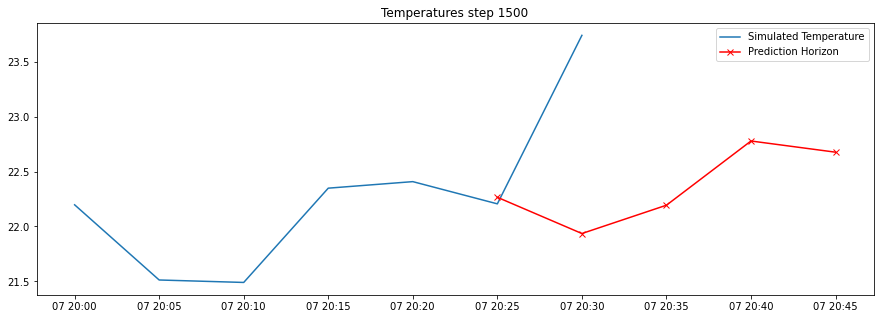

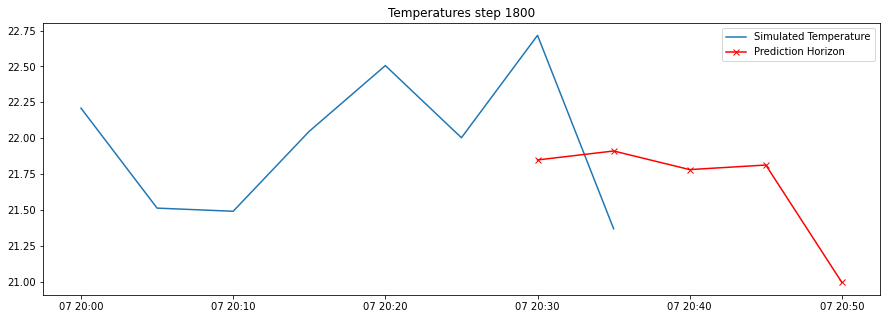

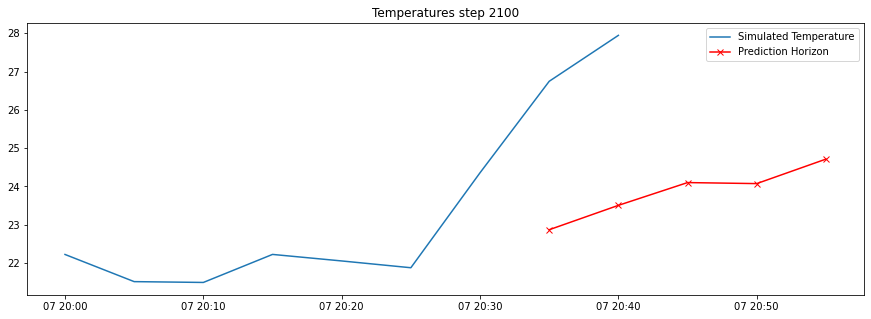

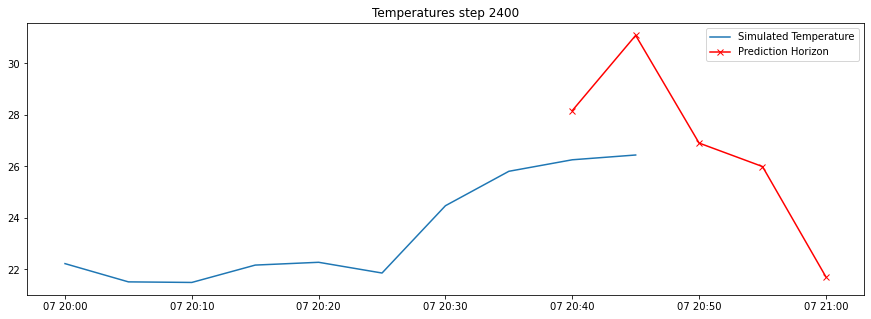

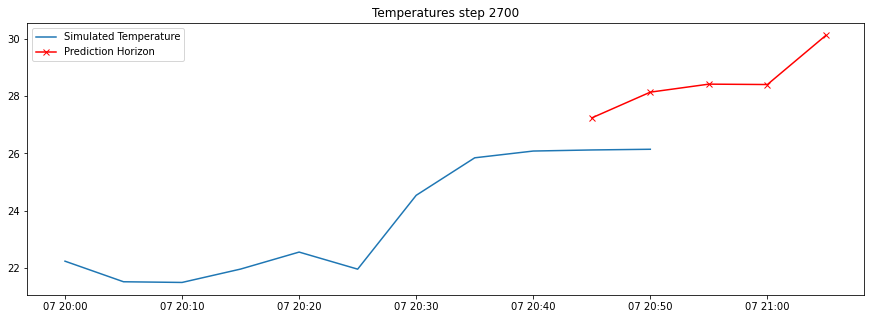

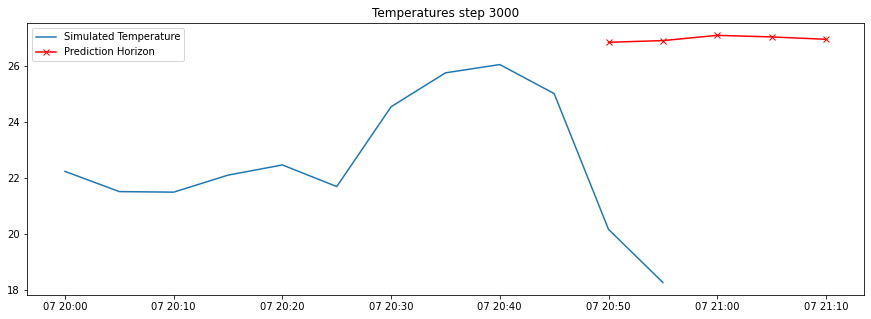

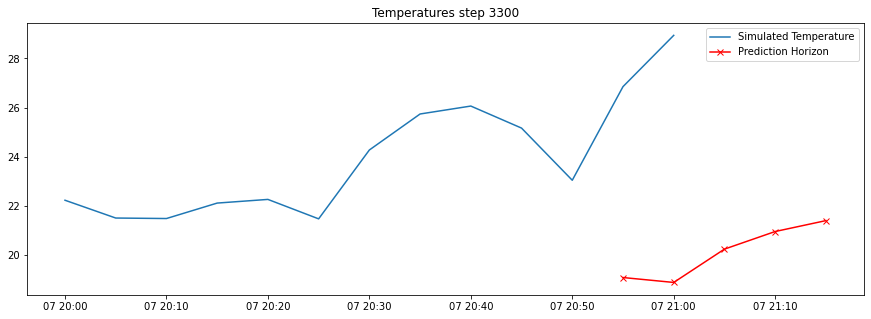

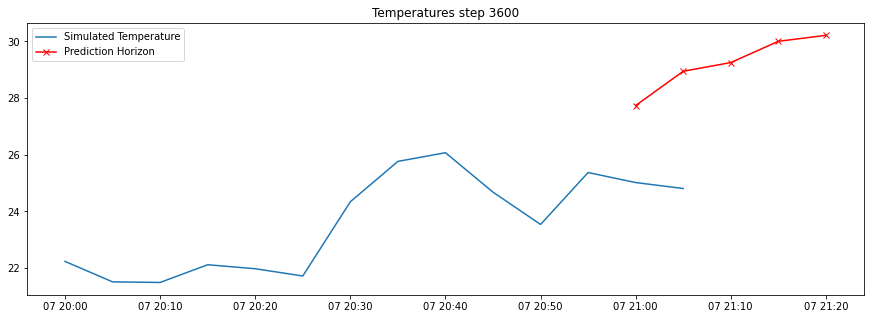

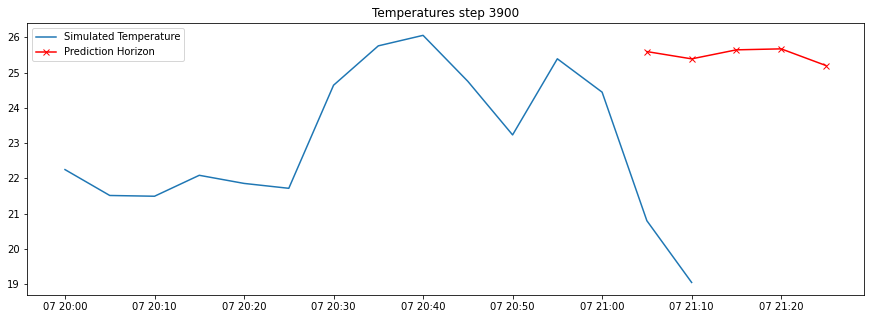

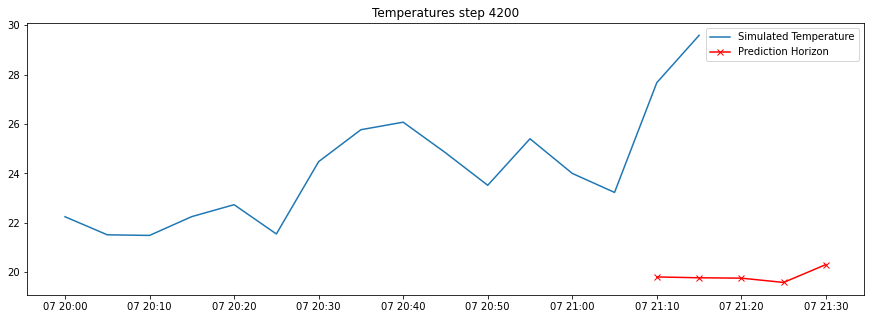

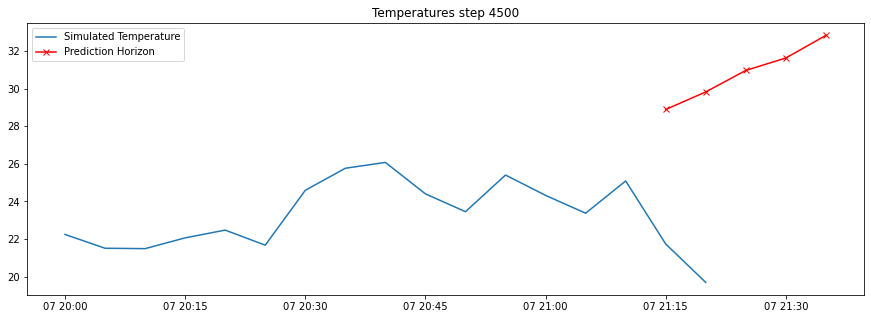

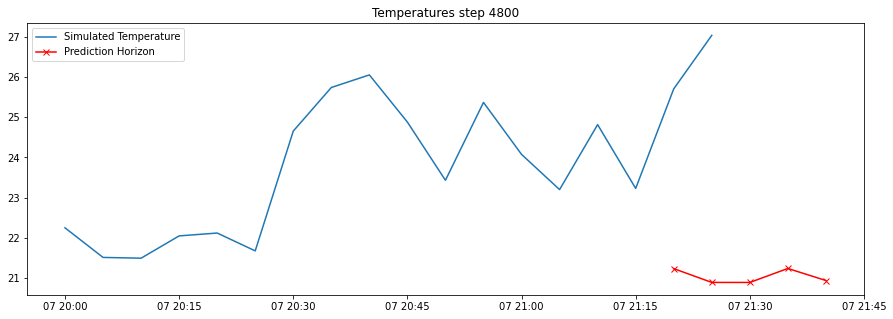

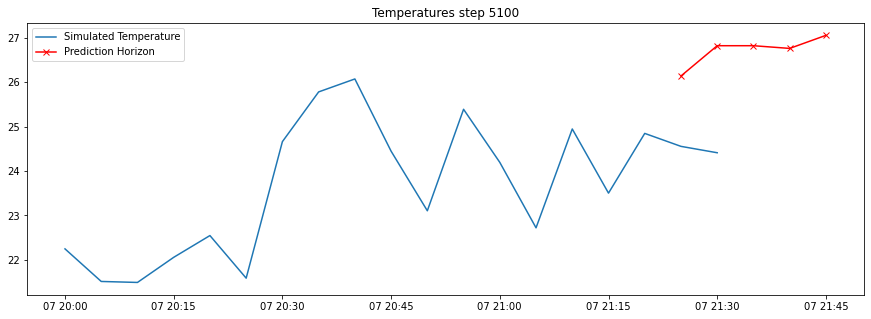

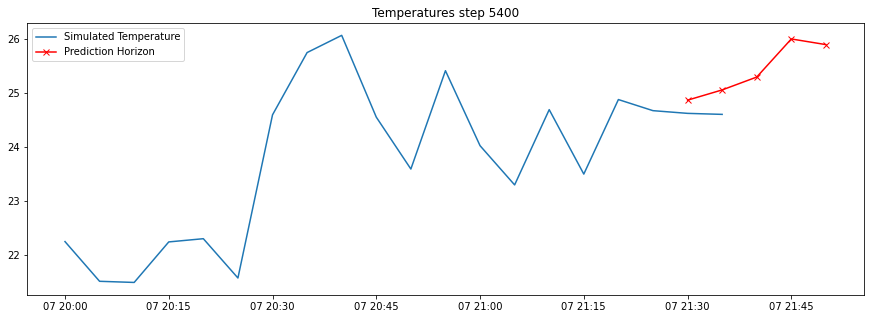

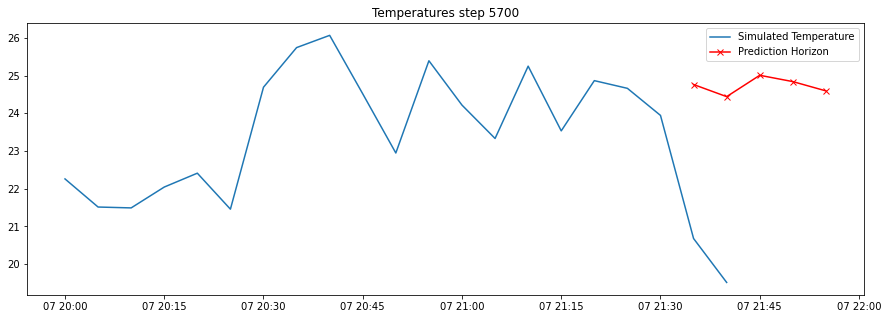

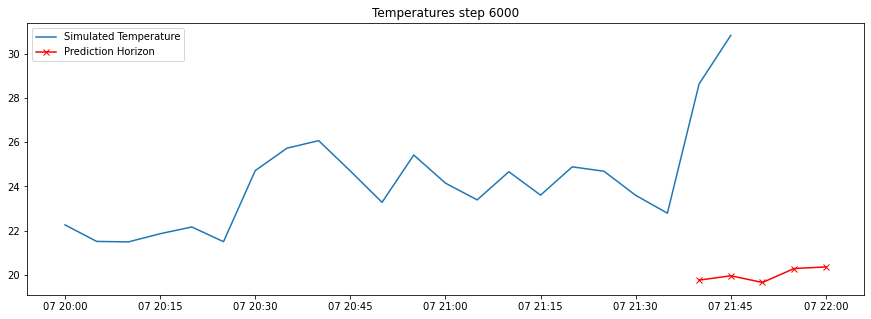

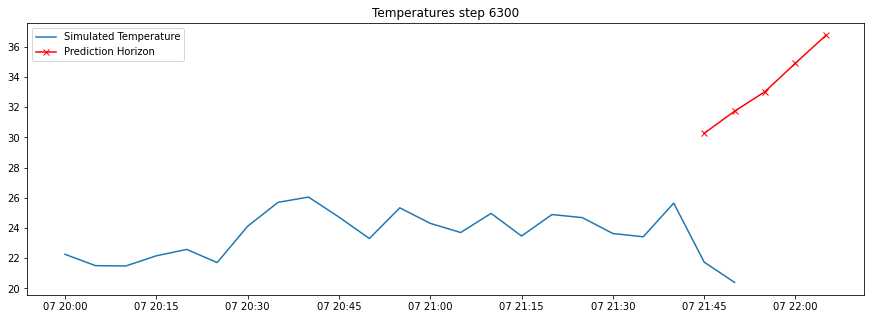

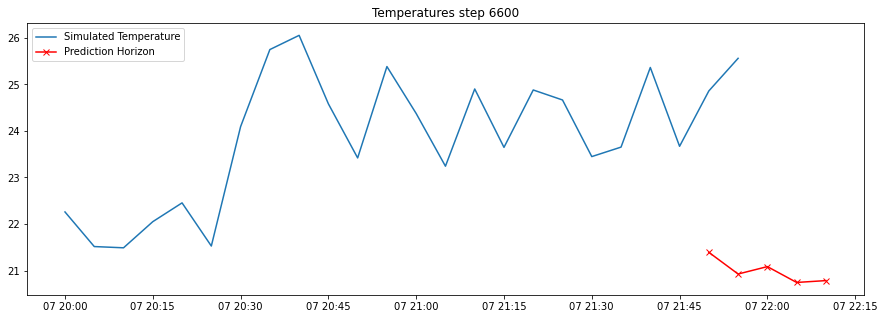

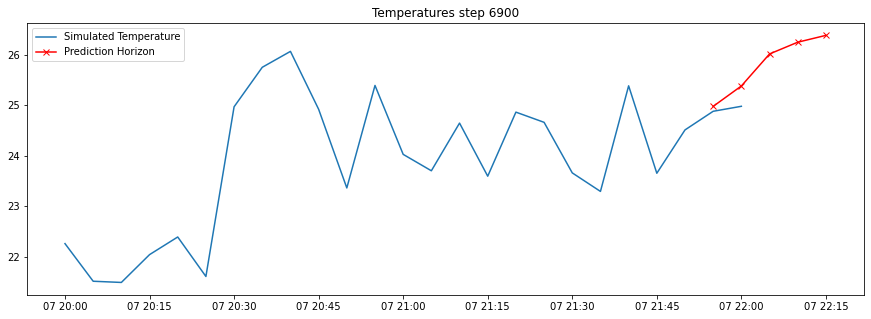

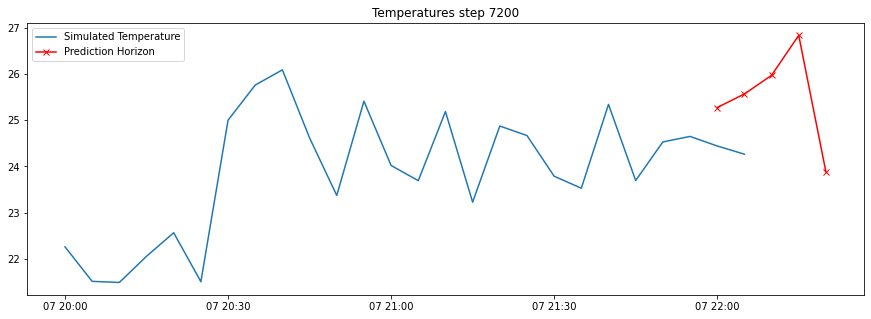

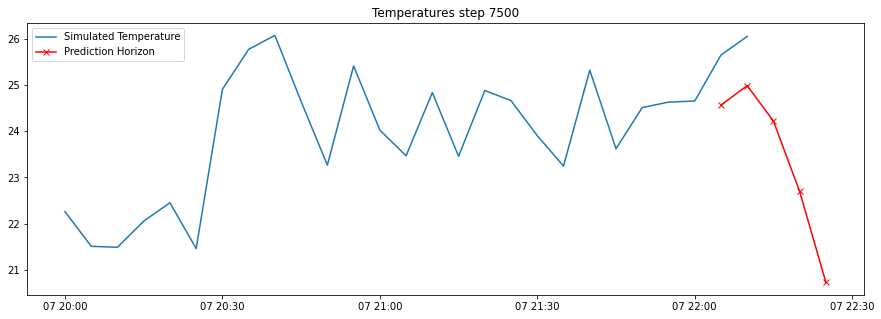

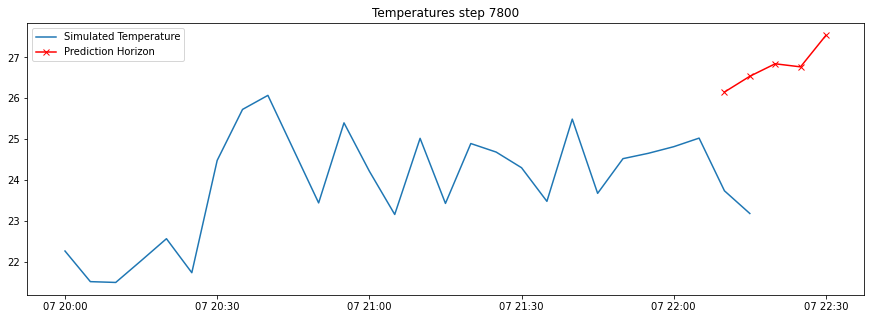

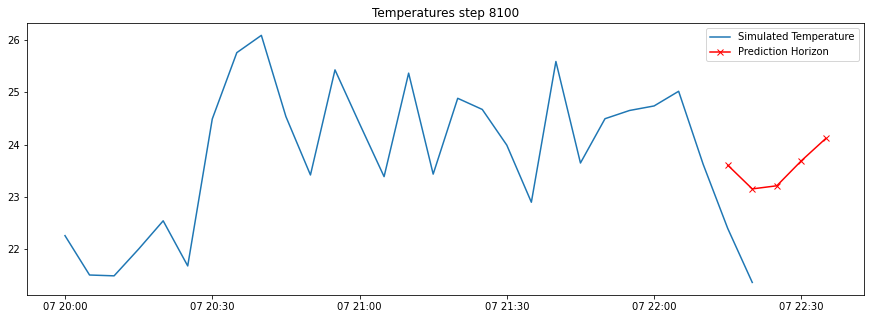

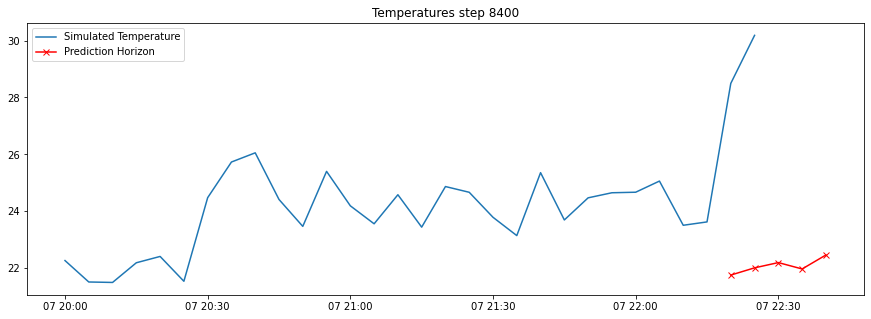

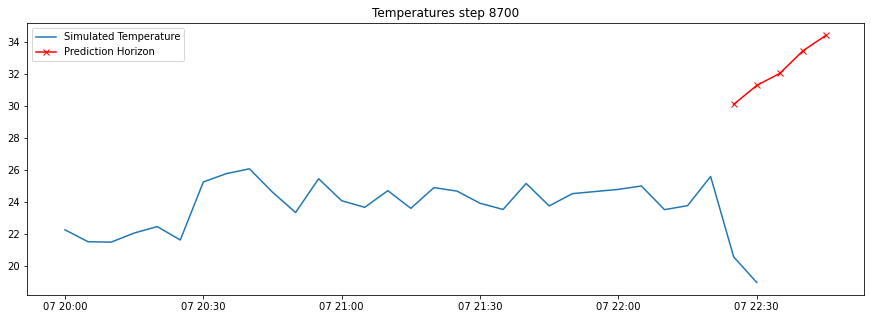

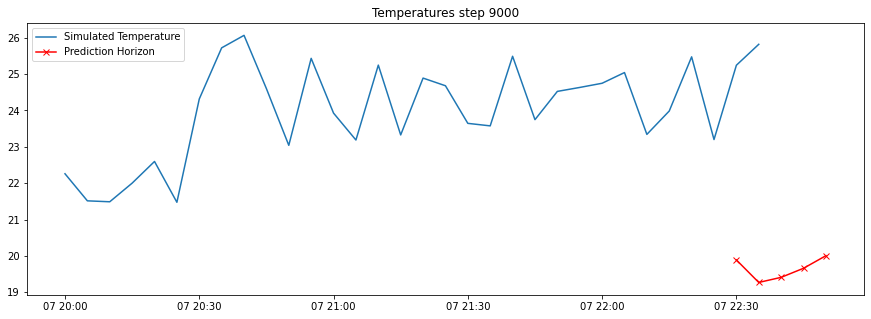

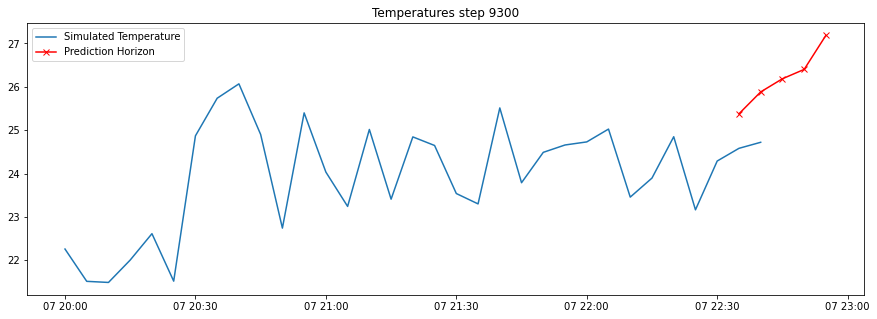

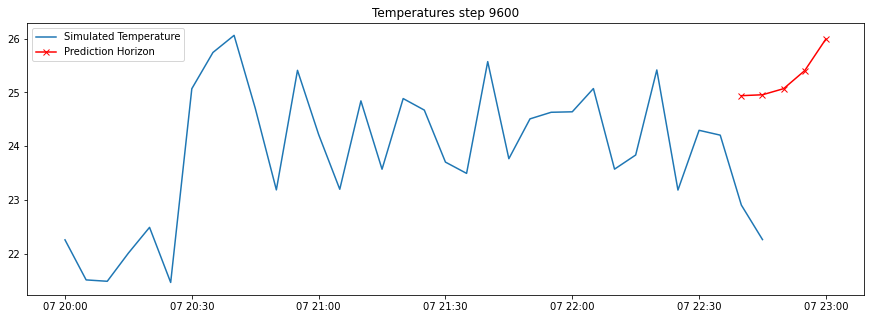

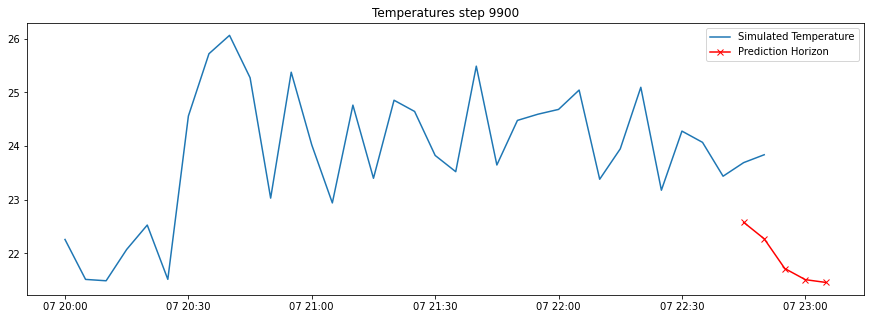

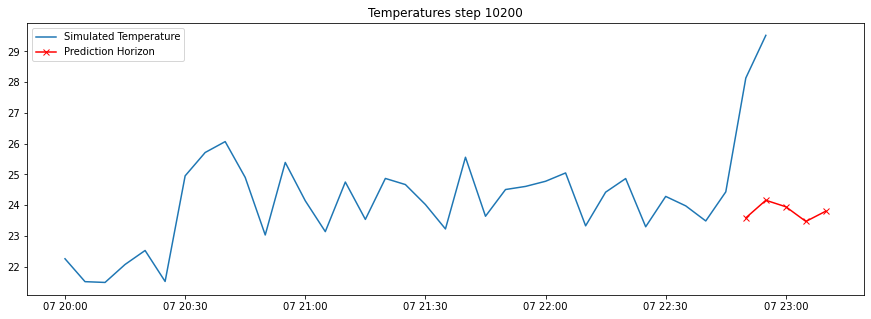

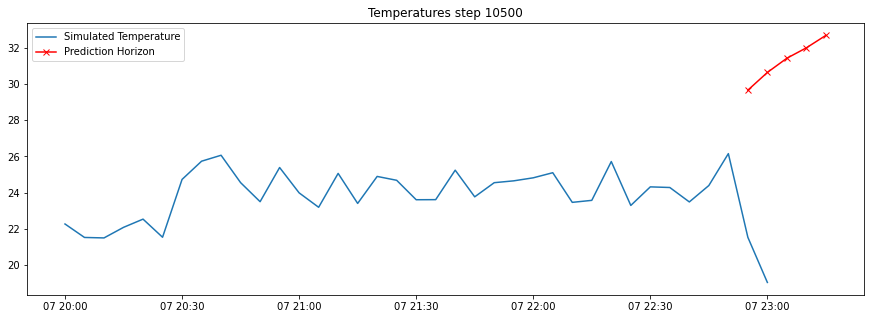

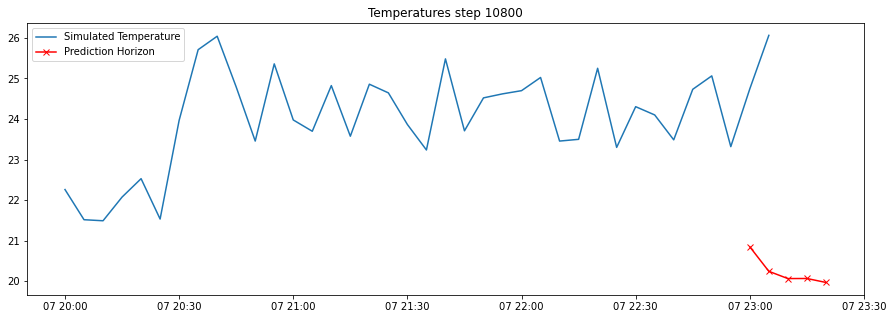

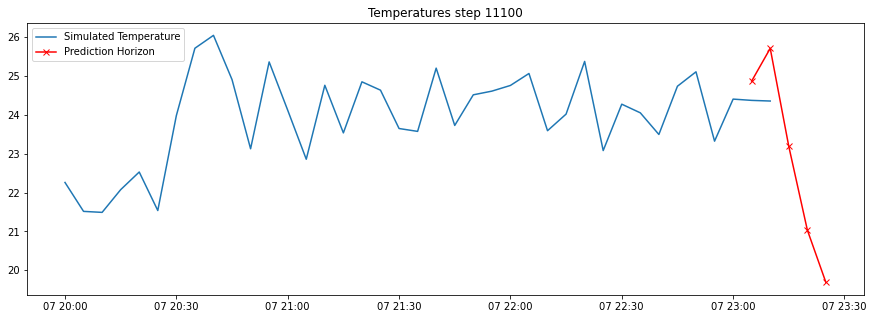

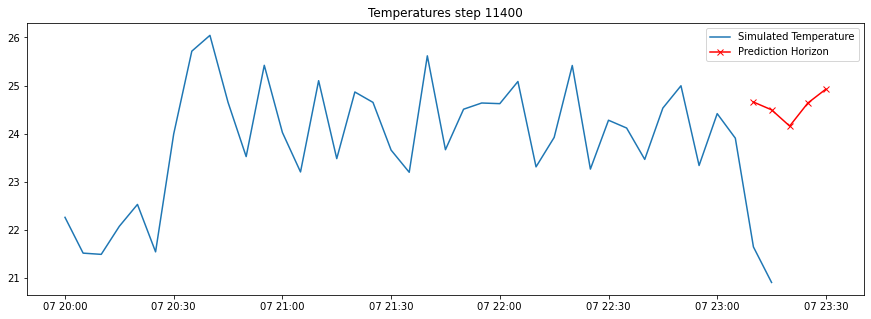

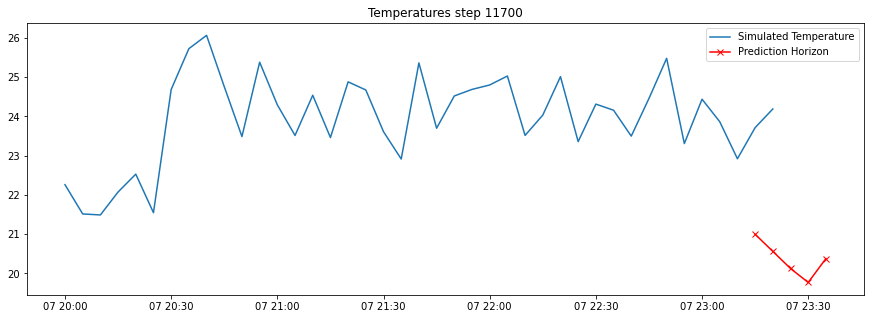

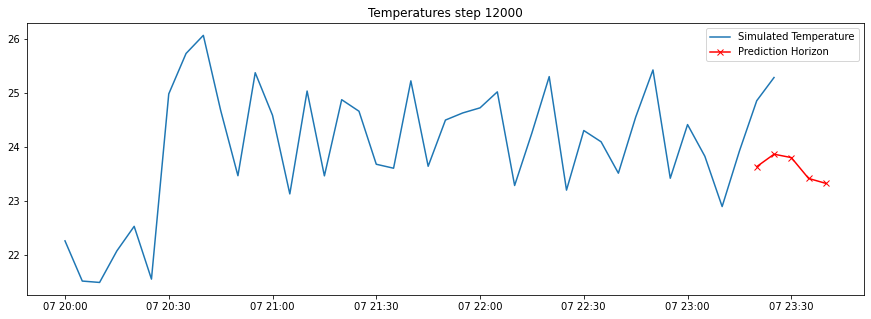

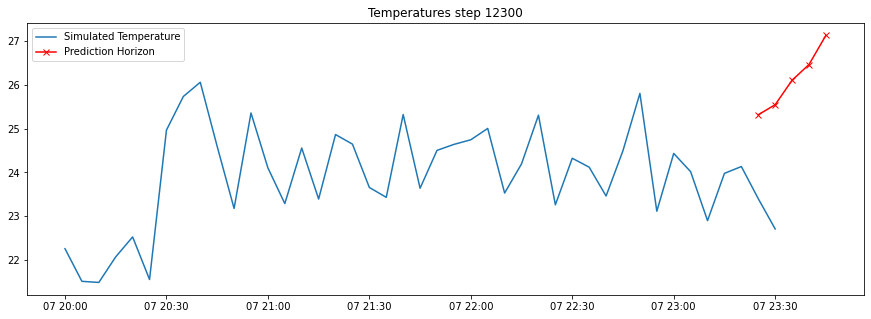

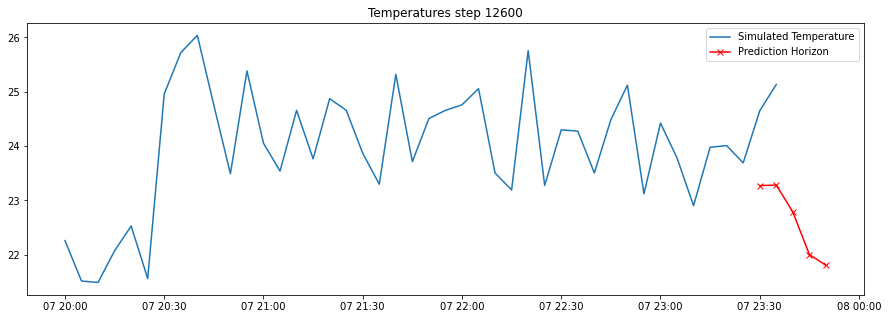

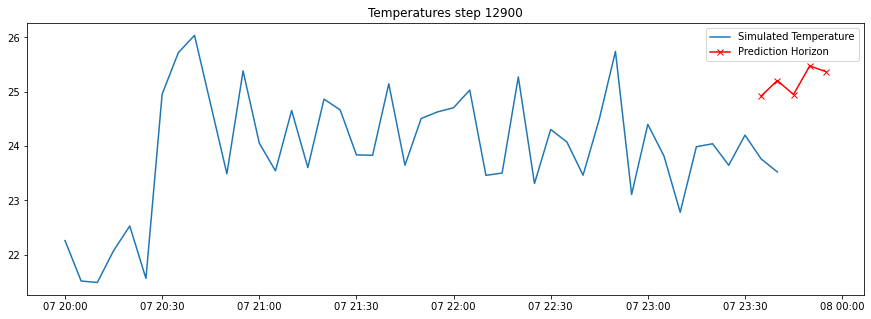

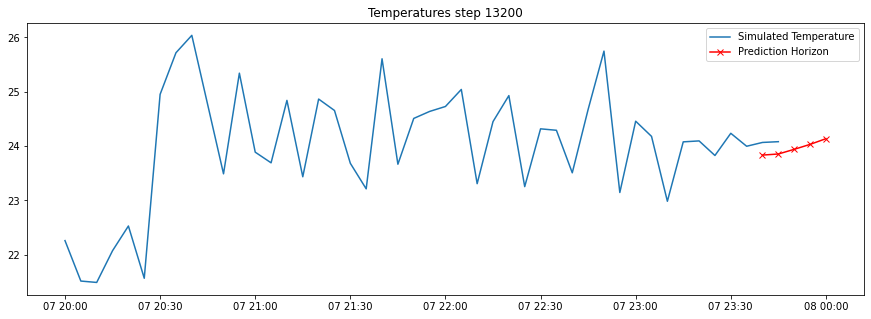

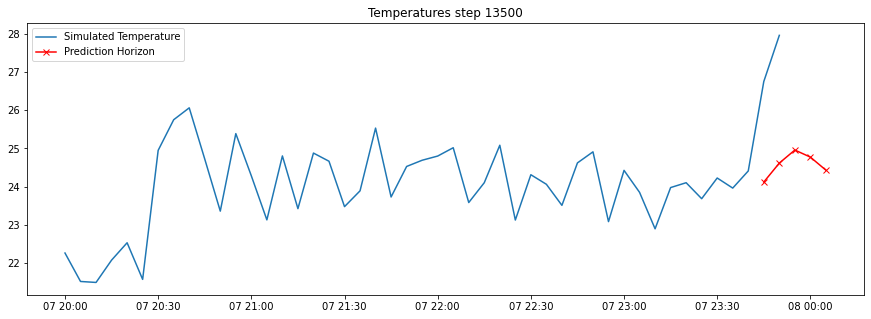

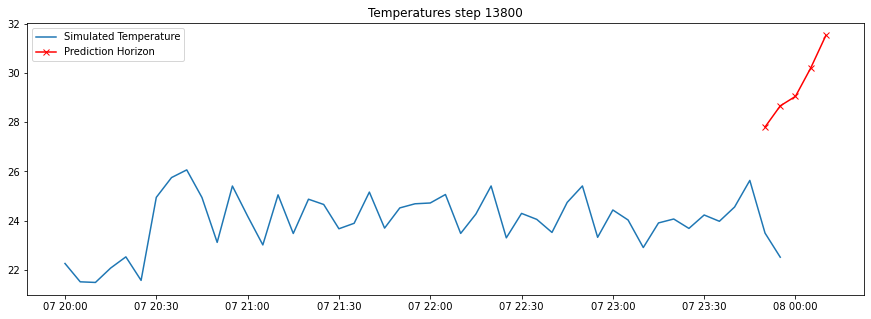

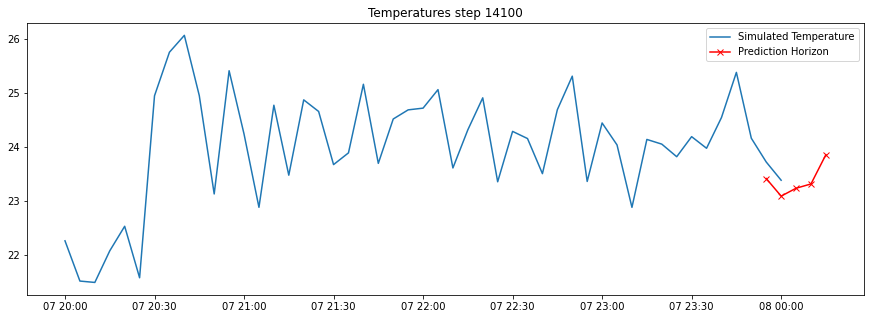

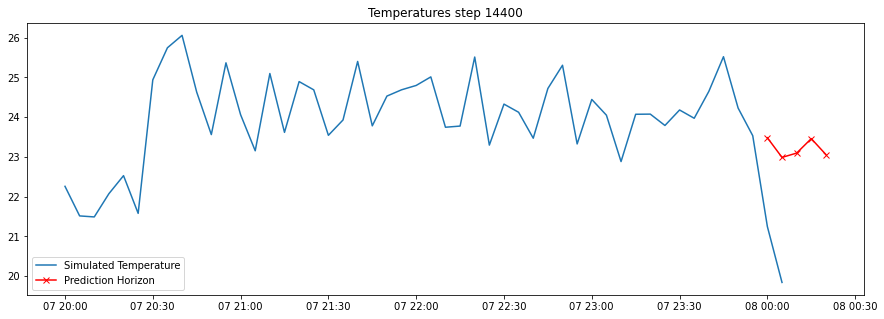

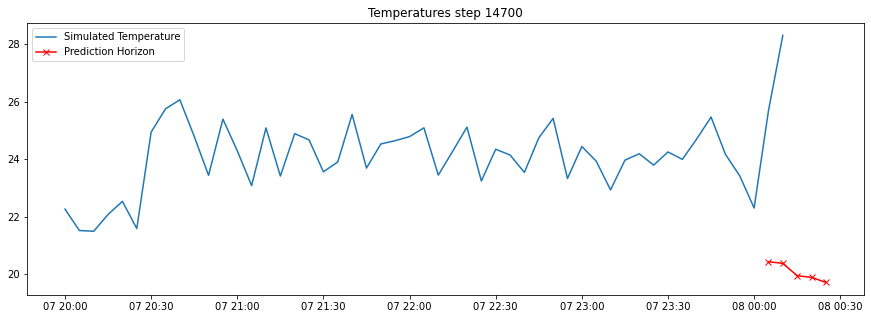

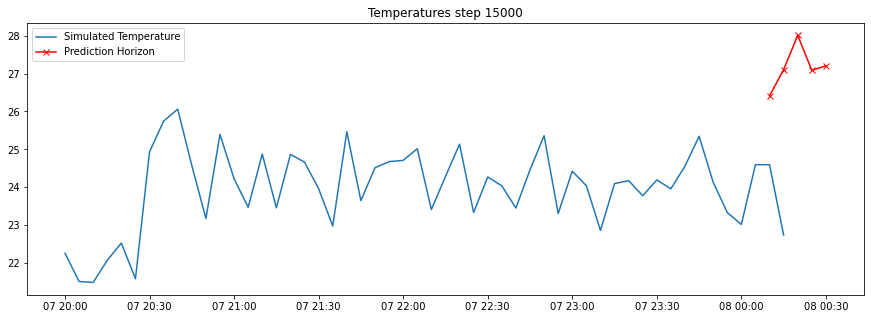

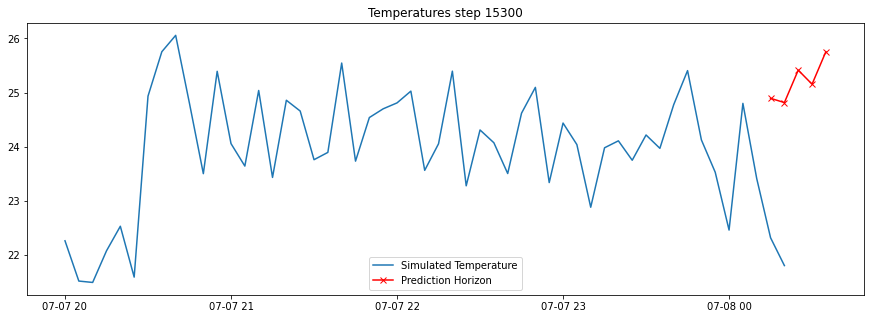

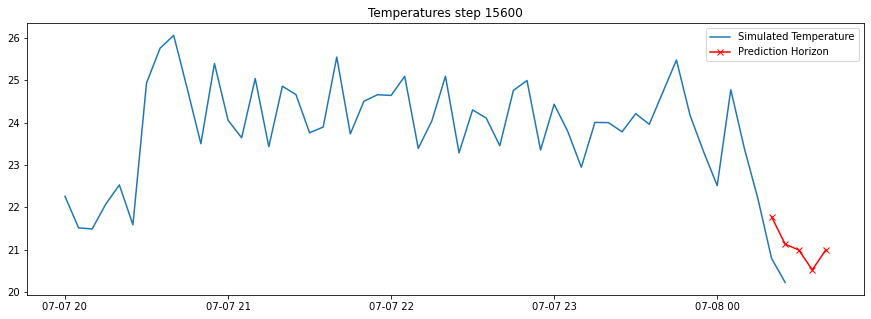

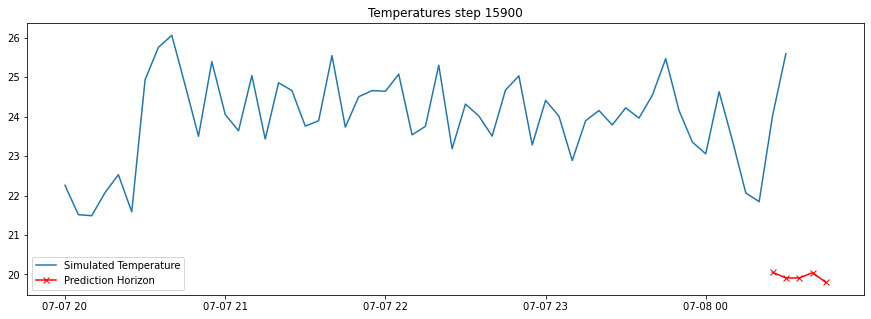

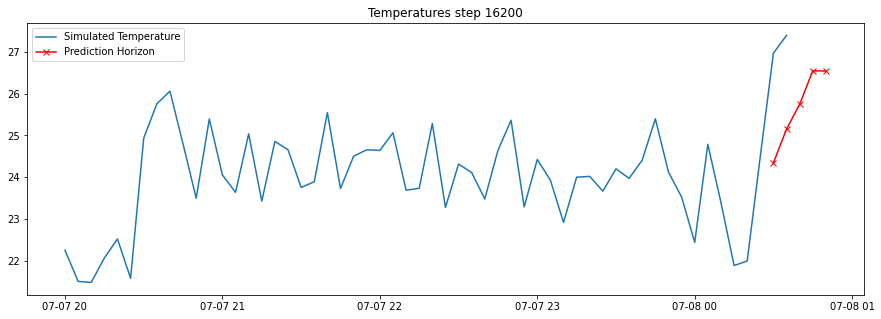

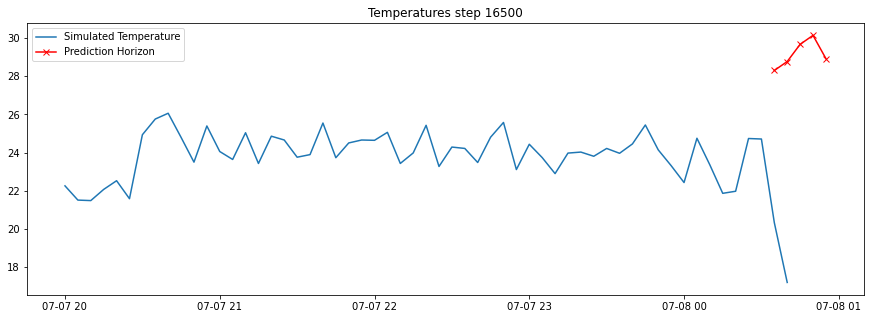

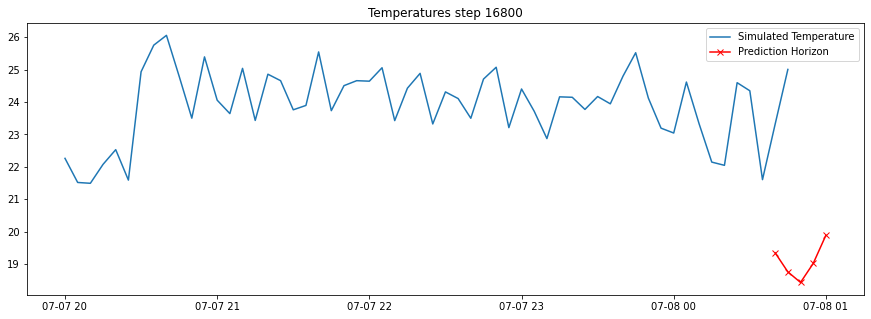

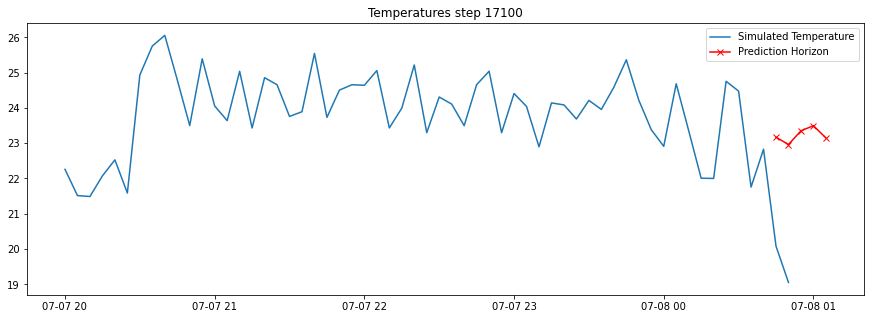

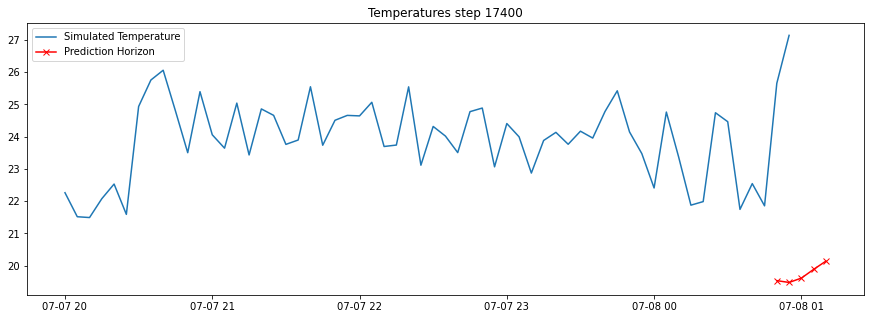

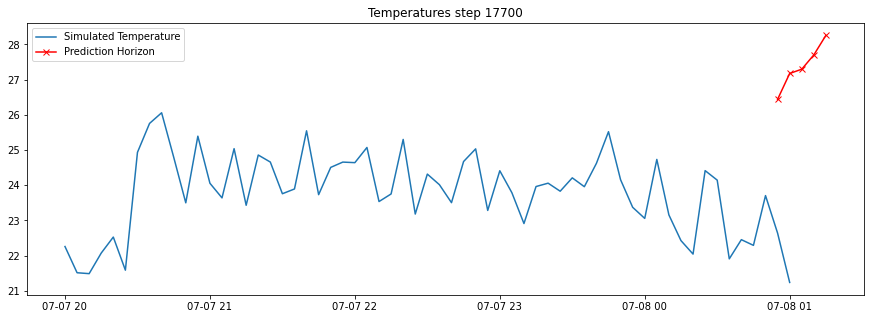

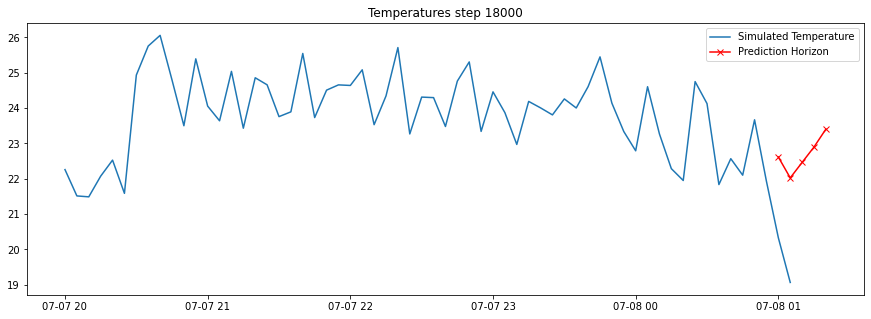

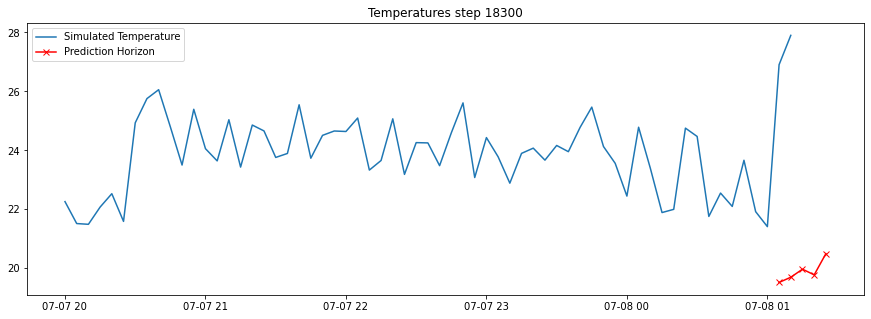

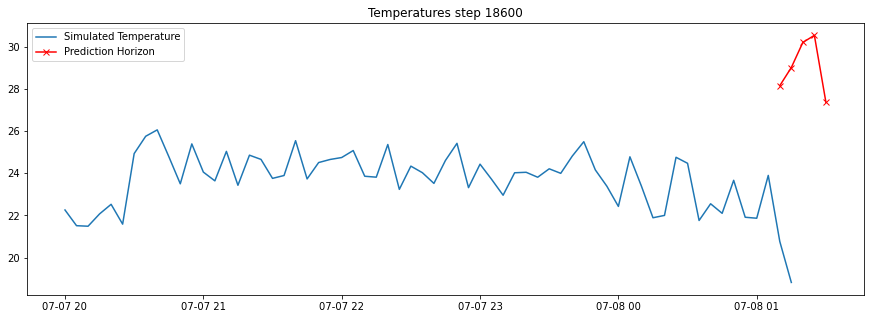

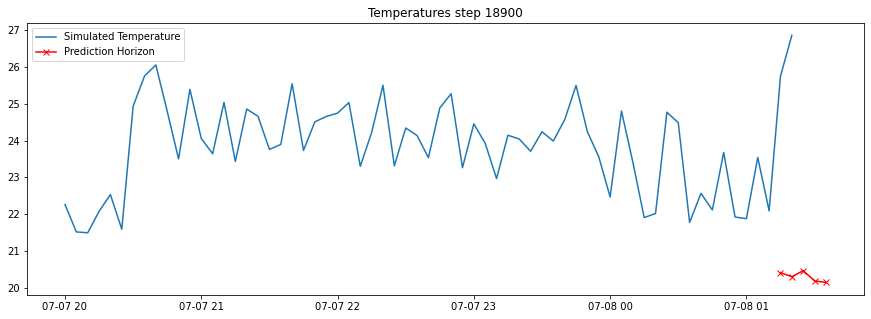

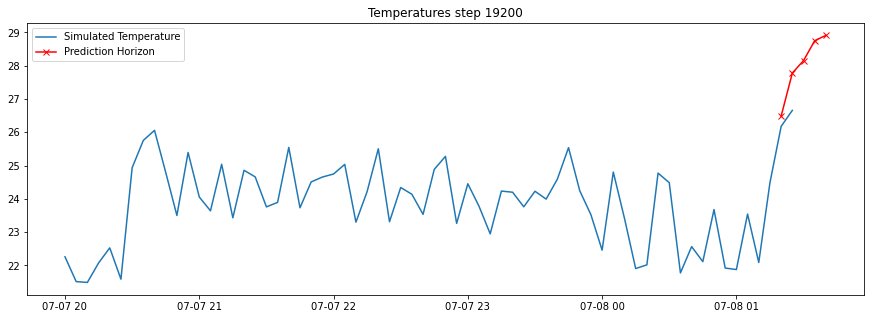

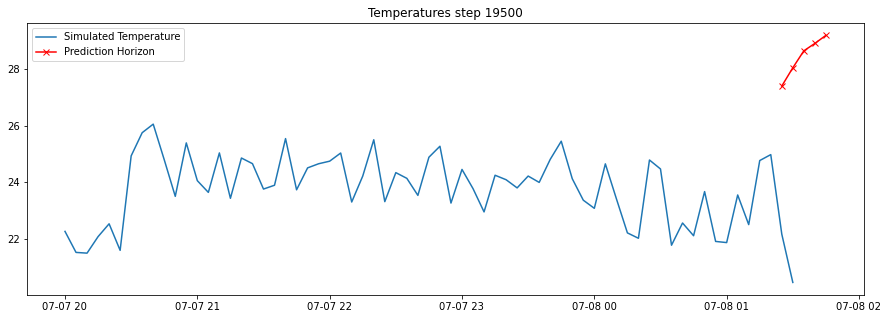

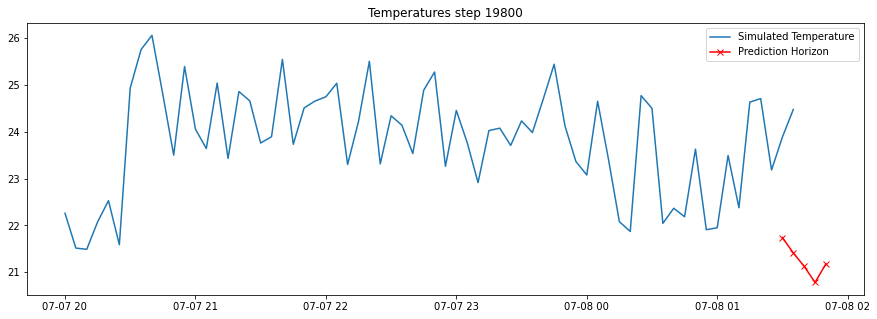

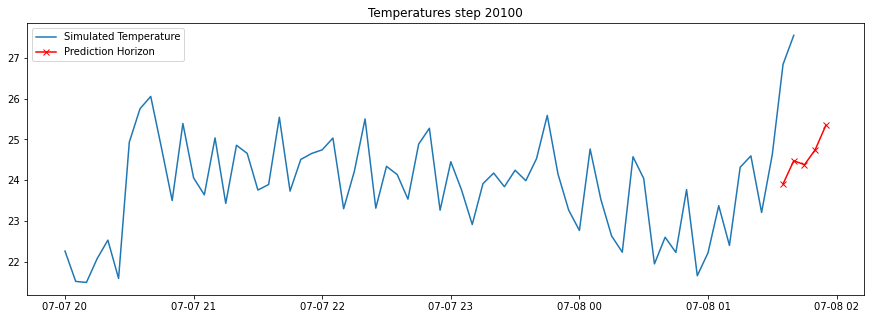

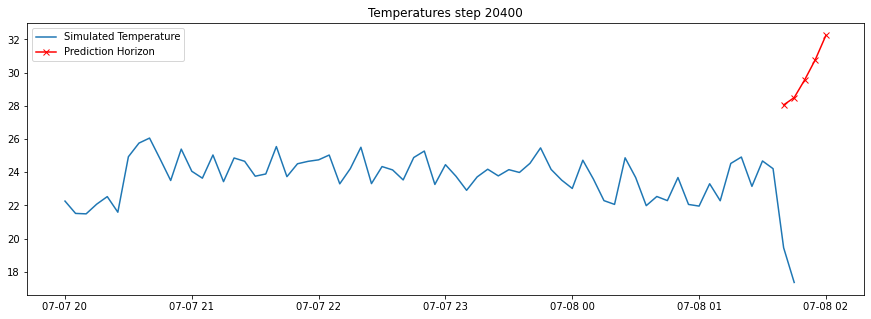

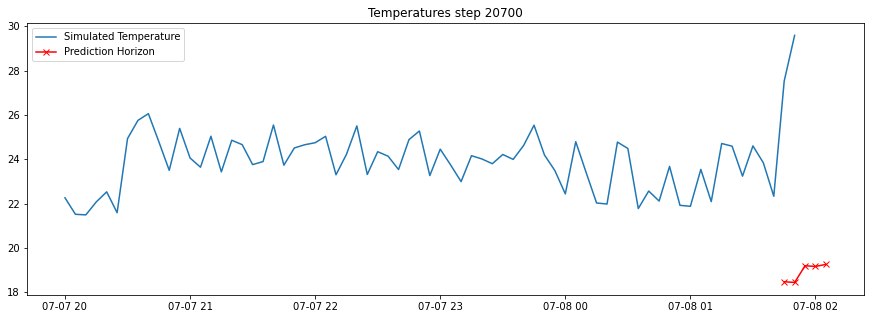

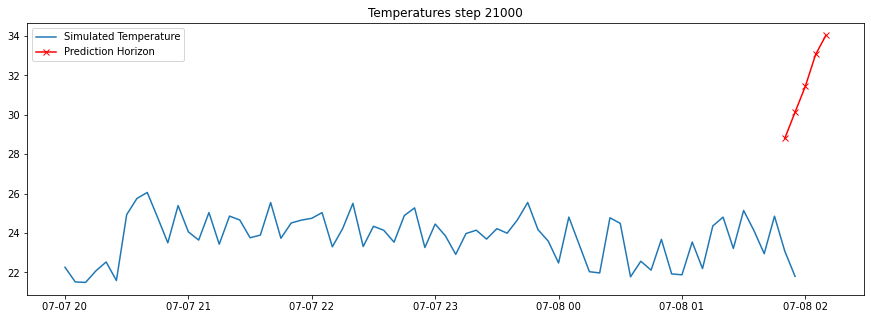

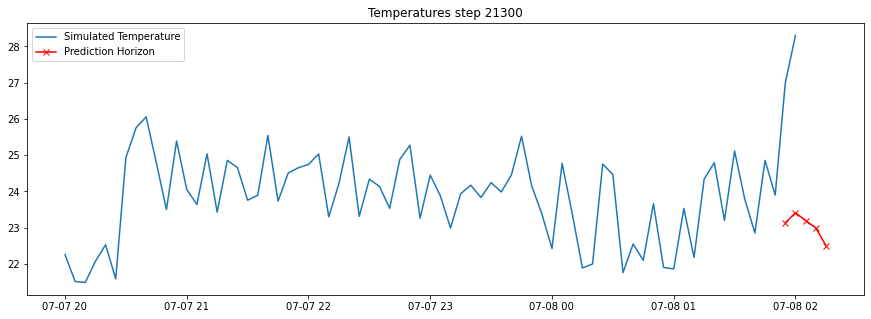

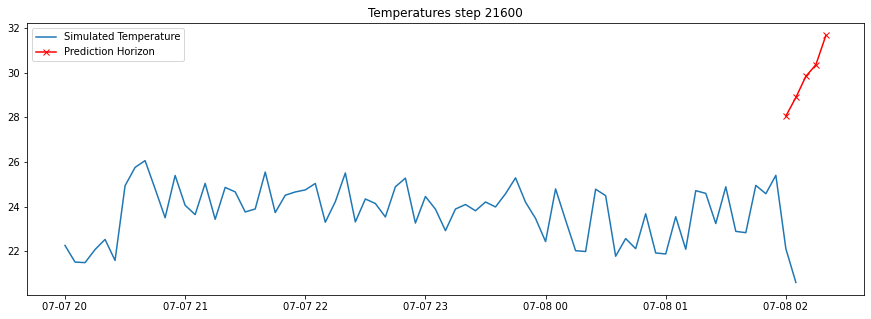

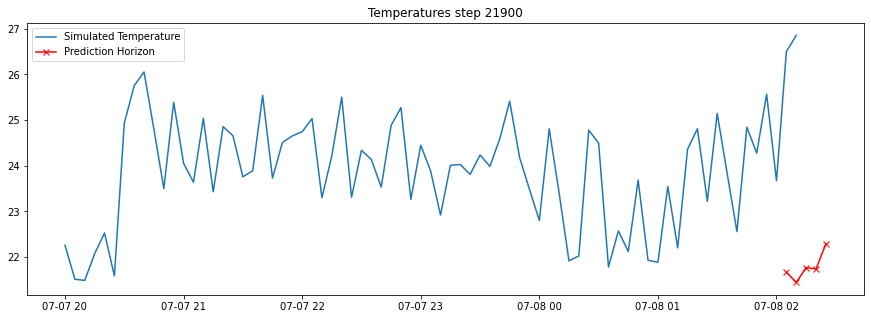

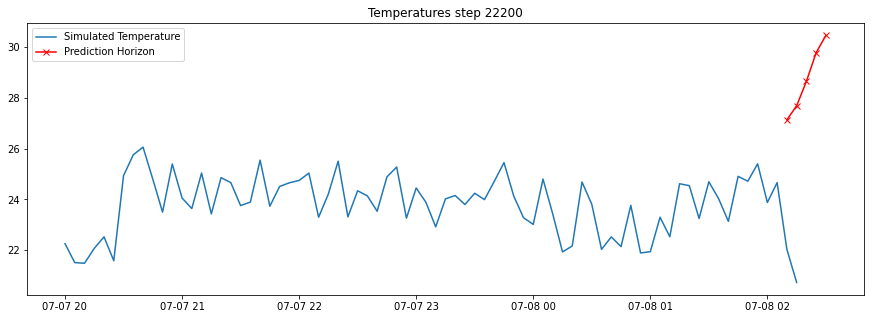

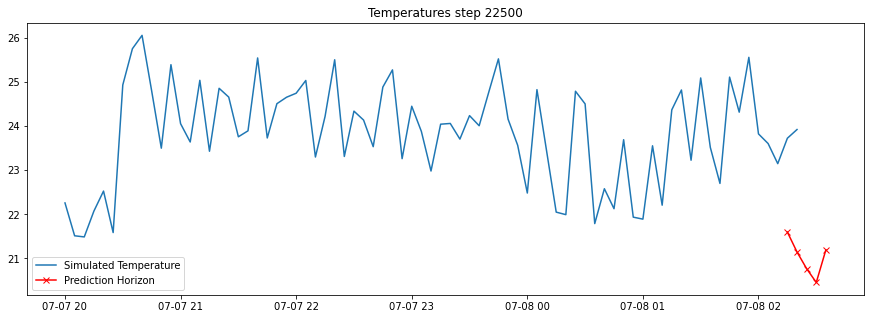

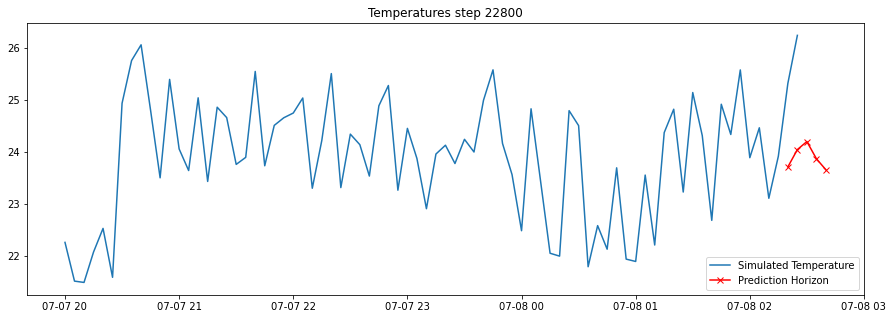

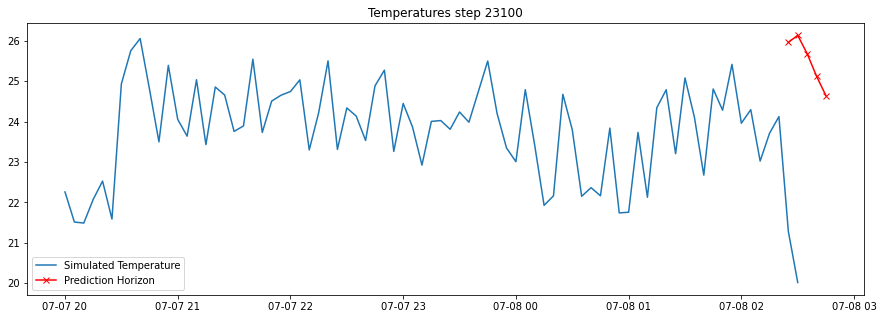

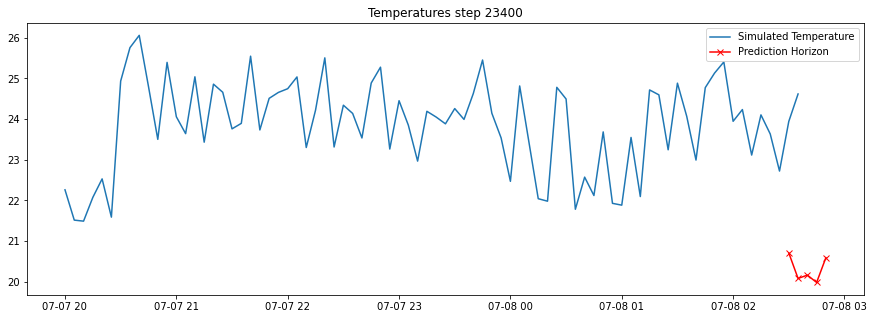

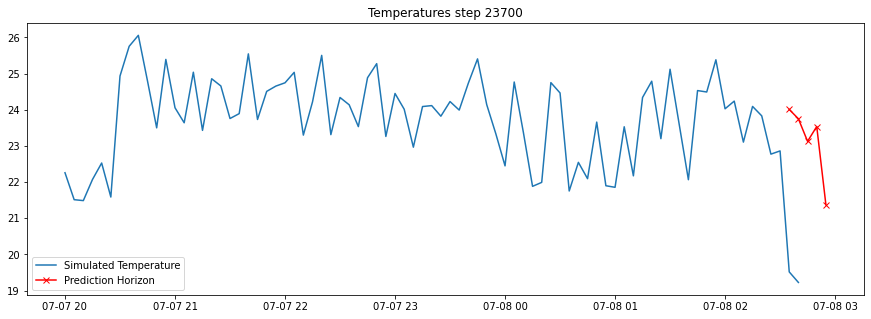

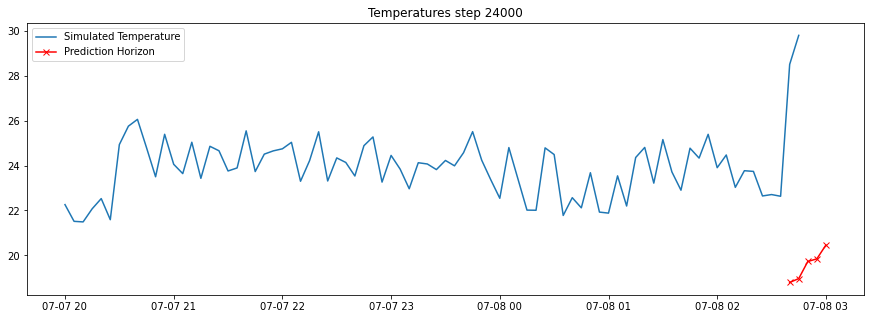

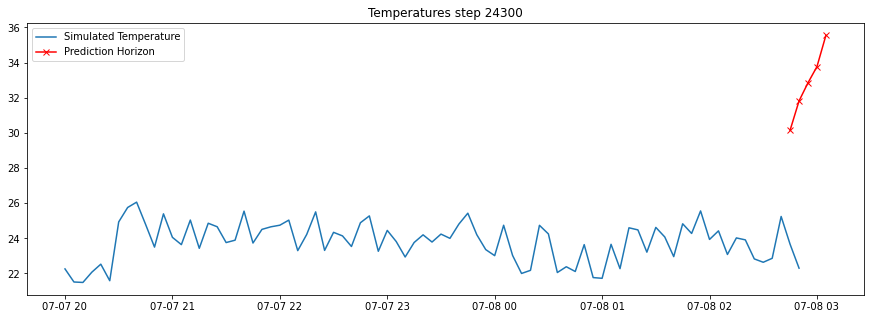

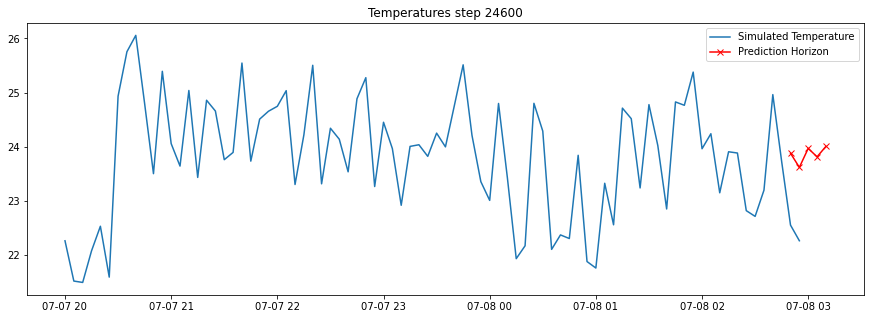

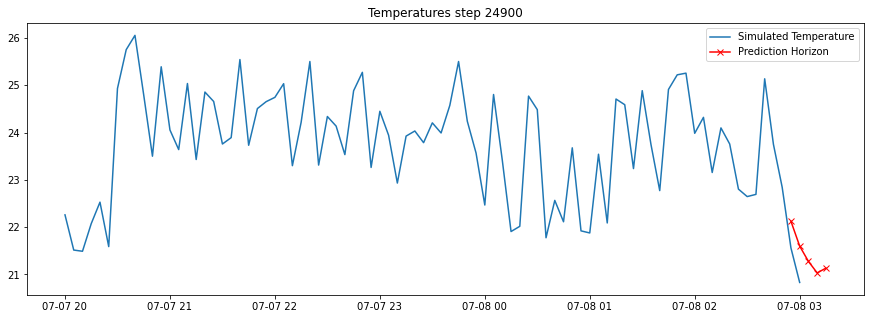

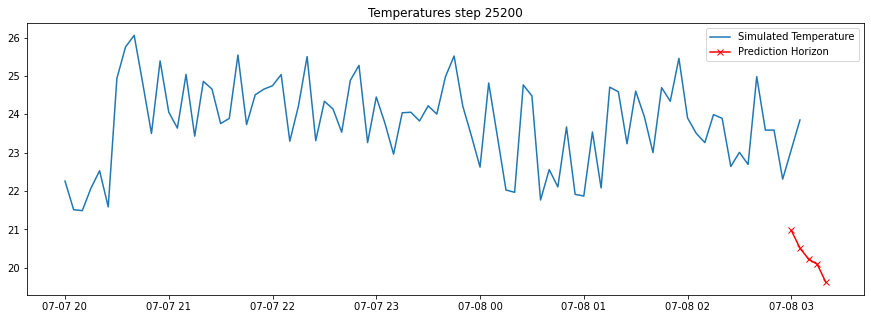

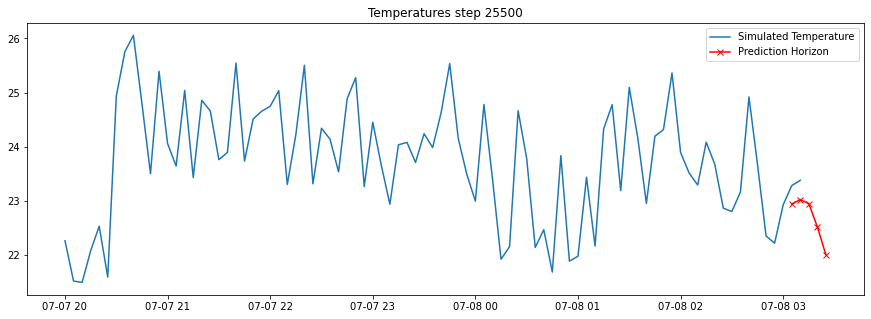

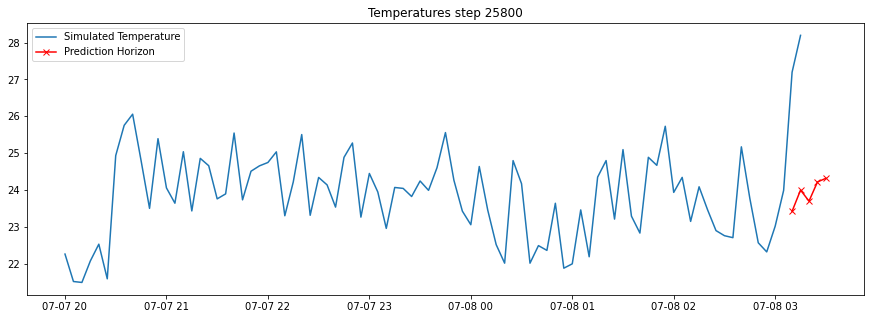

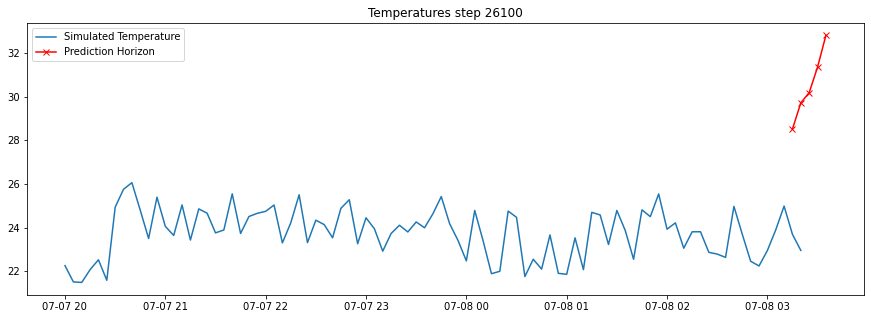

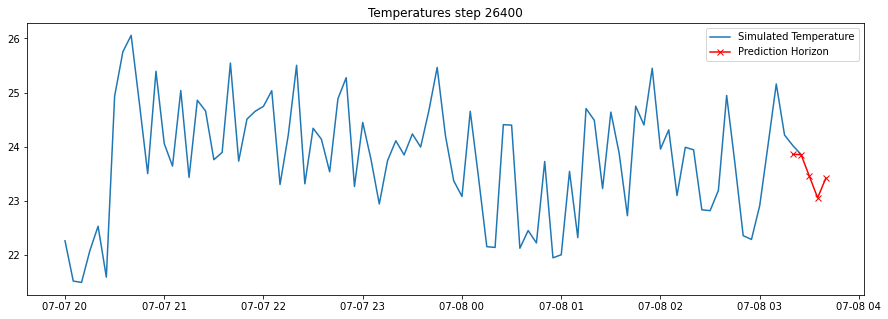

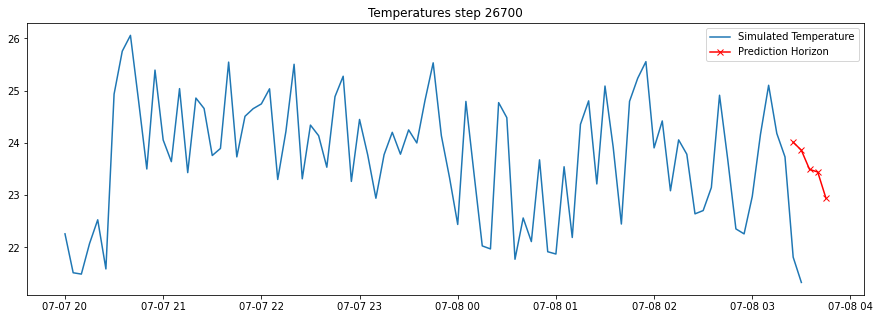

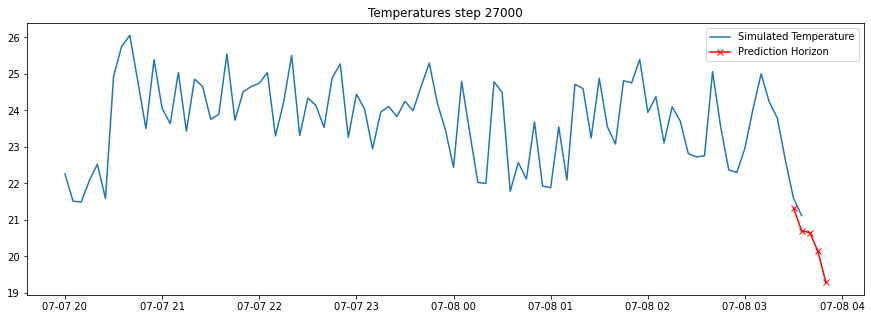

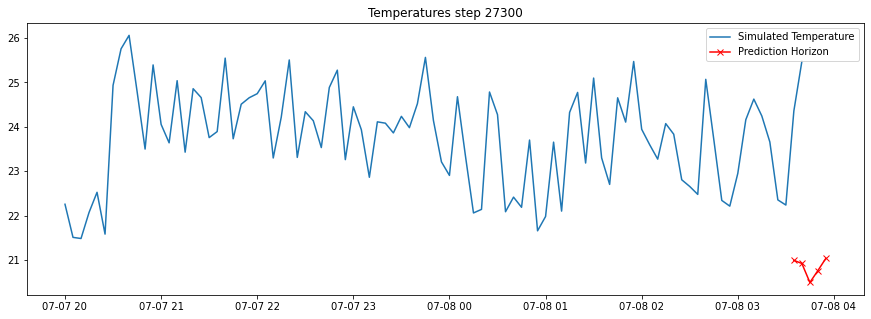

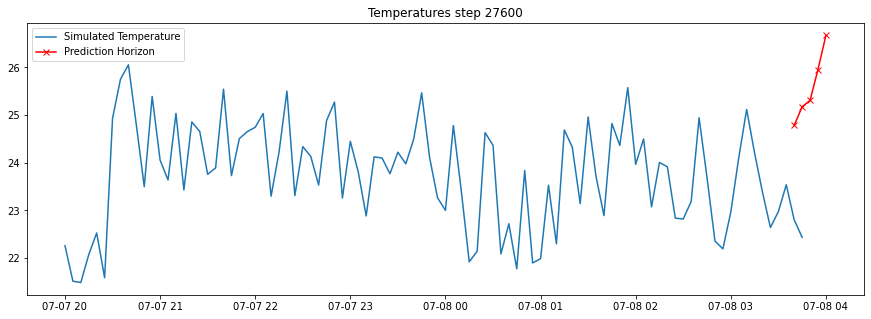

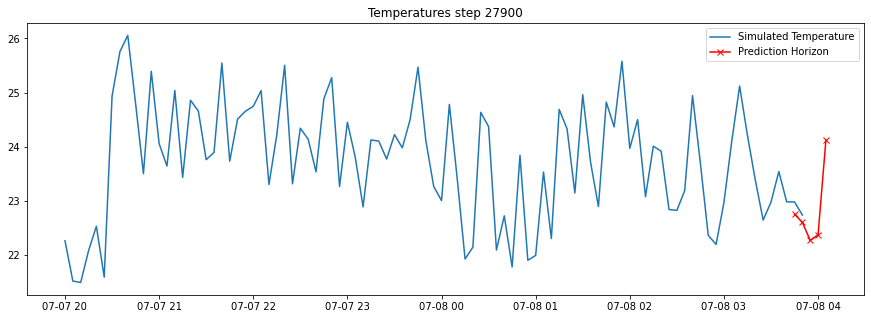

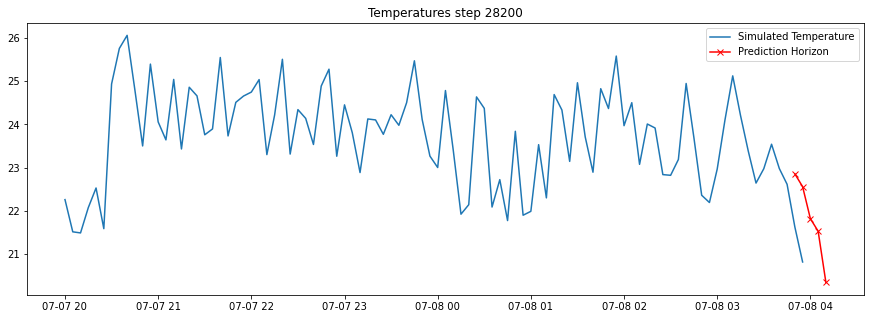

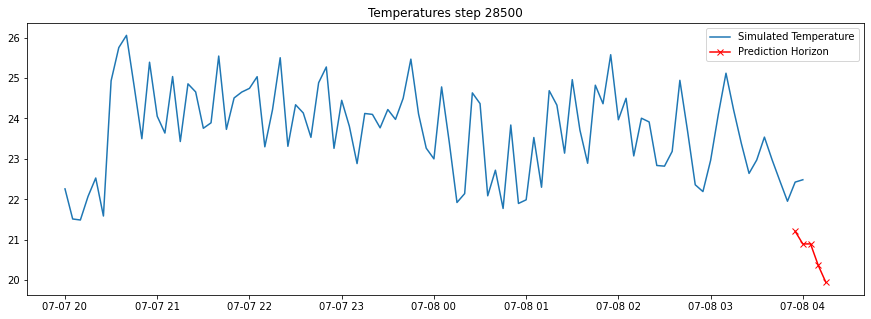

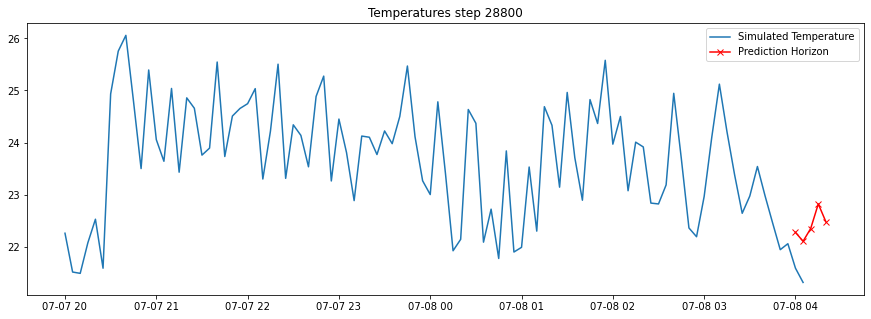

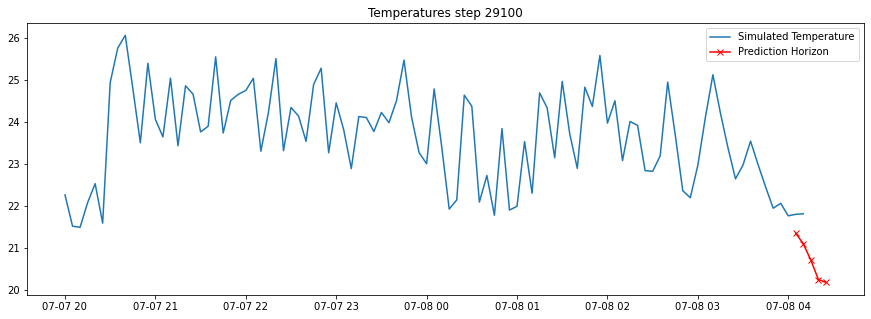

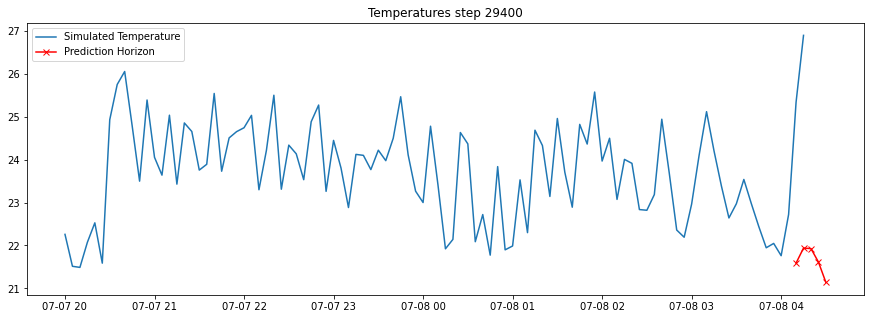

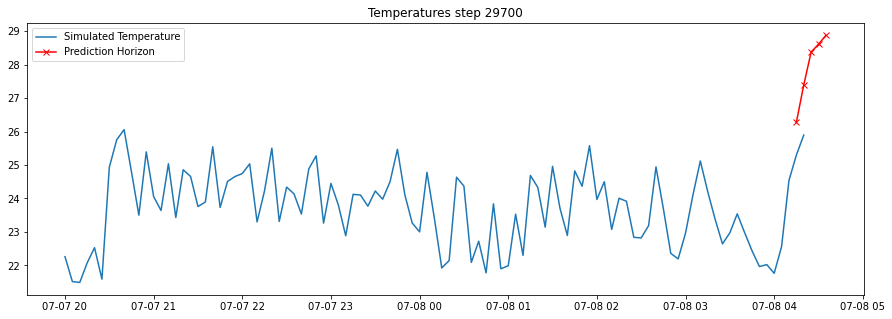

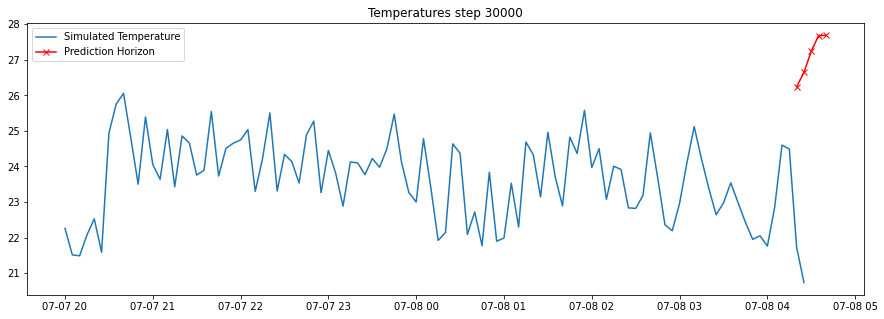

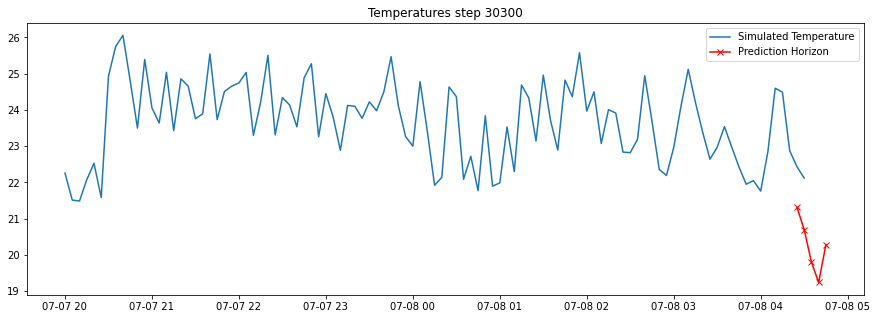

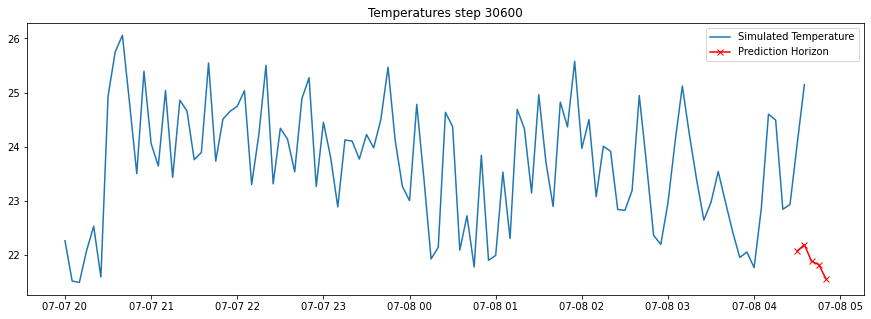

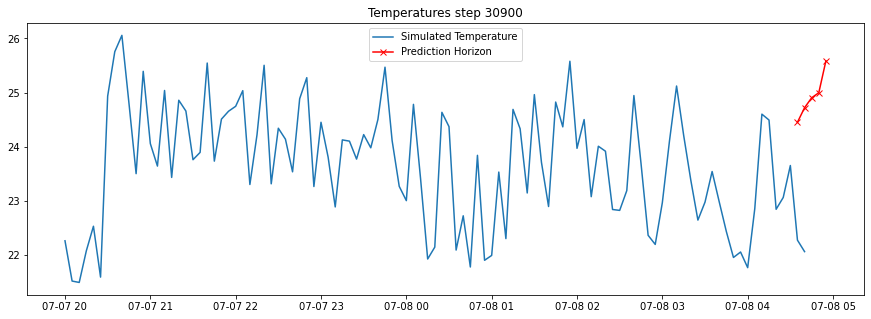

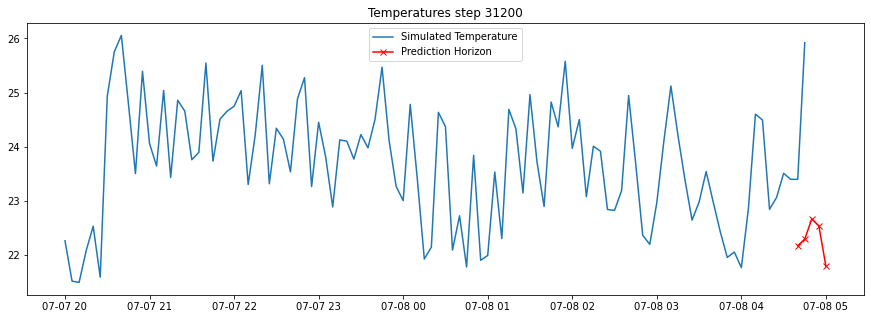

In [386]:
for loop_idx in range(100):
    current_timestamp = 1500 + 300*loop_idx
    print(f"Timestamp {current_timestamp}")
    
    u_1 = float(df_power.loc[df['time'] == (current_timestamp - 300 * 1), 'Heat'])

    y_1 = float(df.loc[df['time'] == (current_timestamp - 300 * 1), 'SimulatedTemp'])
    y_2 = float(df.loc[df['time'] == (current_timestamp - 300 * 2), 'SimulatedTemp'])
    y_3 = float(df.loc[df['time'] == (current_timestamp - 300 * 3), 'SimulatedTemp'])
    
    real_x0 = np.array([u_1, y_1, y_2, y_3])
    iter_idx = (df['time'] >= current_timestamp)
    real_W = df[iter_idx].iloc[:N_horizon, [5, 2]].to_numpy()

    real_p = casadi.vertcat(
        casadi.vec(real_W),
        casadi.vec(real_x0)
    )

    res = solver(p = real_p, lbg = real_lbg, ubg = real_ubg)
    
    df_power.loc[df_power['time'] == current_timestamp, 'Heat'] = res['x'].reshape((N_horizon, -1))[0, 2]
    
    power = np.array(df_power[['time', 'Heat']].dropna())
    eng.workspace['power'] = matlab.double(power.tolist())
    eng.set_param('polydome', 'StopTime', str(current_timestamp + 300), nargout = 0)
    eng.workspace['result'] = eng.sim('polydome')
    
    
    dict_simulation = {}
    dict_simulation['values'] = np.asarray(eng.eval('result.SimulatedTemp.Data')).reshape(-1)
    dict_simulation['time'] = np.asarray(eng.eval('result.SimulatedTemp.Time')).reshape(-1)
    
    df_simulation = pd.DataFrame(dict_simulation)
    #df_simulation['time'] = df_simulation['time'].astype(int)
    df_simulation.set_index('time', inplace = True, drop = True)
    
    df_simulation['timestamp'] = df.index[0] + df_simulation.index.map(lambda x: pd.Timedelta(seconds = x))
    df_simulation = df_simulation.reset_index().set_index('timestamp')
    df_resampled_5 = df_simulation['values'].resample('5min').mean().pad()
    df_simulation = pd.concat([df['time'], df_resampled_5], axis = 1)
    
    df.loc[:, 'SimulatedTemp'] = df_simulation['values']
    T_sim_horizon = np.array(gpr(res['x'].reshape((N_horizon, -1)).T))
    simul_idx = (df_simulation['time'] >= current_timestamp) & (df_simulation['time'] < (current_timestamp + N_horizon * 300))
    
    
    df_T_sim_horizon = df_simulation[simul_idx].copy()
    df_T_sim_horizon.loc[:, 'values'] = T_sim_horizon.reshape((-1, ))
    
    plt.figure(figsize = (15, 5))
    plt.plot(df_simulation.index, df_simulation['values'], label = 'Simulated Temperature')
    plt.plot(df_T_sim_horizon.index, df_T_sim_horizon['values'], label = 'Prediction Horizon', color = 'red', marker = 'x')
    #plt.plot(df.index, df['InsideTemp'], label = 'Inside Temperature')
    #plt.plot(df.index, df['OutsideTemp'], label = 'Outside Temperature')
    plt.title(f'Temperatures step {current_timestamp}')
    plt.legend()
    plt.savefig(f"sim_{current_timestamp}.png")